In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import accuracy, f1_score


In [2]:
horrorDF = pd.read_excel(
    "../DATA/2조 괴담 파일.xlsx", skiprows=0, header=1, sheet_name="SY", usecols=[3]
)


In [3]:
horrorDF


,TEXT
0,오늘 학교에서 모의고사보는데 가위눌리다가 한쪽눈만 떠진상태로 교실에서 내 다리에 올...
1,그녀는 날 사랑한다... 안 사랑한다... 날 사랑한다... 안 사랑한다...날 사...
2,"어린애같지만, 난 항상 지하실에서 나갈때 내 뒤를 쳐다보면서 계단을 뛰어 올라가. ..."
3,생리혈에 덩어리 같은게 있을수 있다는건 나도 알아. 근데 그게 보통 움직이는거야?\n
4,"난 별 생각없이 ""우리 모두 다함께 손뼉쳐!"" 라고 외쳤어. 다락방에서 박수 소리를..."
...,...
994,희망봉근해에 출몰하는 네덜란드 동인도회사의 유령선을 플라잉더치맨이라고 부른다. 알류...
995,"T 씨가 잠에서 깨자, 1년이 경과해있었다.하지만 기억상실은 아니다.가족도, 친구도..."
996,아르메니아 쿠니크호수에는 딱 스와코 *오미와타리 같은 자연현상이 일어난다. 호반 교...
997,"적도상 3만 6000킬로에 해당하는 우주 공간에, 길이 50M의 거대 물체가 떠있..."


In [4]:
horrorSR = horrorDF["TEXT"].str.replace(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z\d ]", "", regex=True)
horrorSR.info()


<class 'pandas.core.series.Series'>
RangeIndex: 999 entries, 0 to 998
Series name: TEXT
Non-Null Count  Dtype 
--------------  ----- 
999 non-null    object
dtypes: object(1)
memory usage: 7.9+ KB


In [5]:
sentences = horrorSR.to_list()[:10]
sentences


['오늘 학교에서 모의고사보는데 가위눌리다가 한쪽눈만 떠진상태로 교실에서 내 다리에 올라와있는 귀신봤어',
 '그녀는 날 사랑한다 안 사랑한다 날 사랑한다 안 사랑한다날 사 어 더 이상 떼어낼 팔다리가 없네 넌 처음부터 날 사랑하지 않았구나',
 '어린애같지만 난 항상 지하실에서 나갈때 내 뒤를 쳐다보면서 계단을 뛰어 올라가 난 잘못된 방향을 바라보고 있었었어',
 '생리혈에 덩어리 같은게 있을수 있다는건 나도 알아 근데 그게 보통 움직이는거야',
 '난 별 생각없이 우리 모두 다함께 손뼉쳐 라고 외쳤어 다락방에서 박수 소리를 들리기 전까진 난 내가 집에 혼자있는줄 알았어',
 '난 숲속에서 일회용 카메라를 발견했다 필름을 현상했을때 그곳엔 내가 처음으로 카메라를 발견했을때의 모습이 찍힌 사진 딱 한장만이 찍혀있었다',
 '우리 할머니는 심한 치매에 걸리셨다 매일 저녁 난 할머니가 2년전에 이미 돌아가셨다고 설명하지만 허사다',
 '버스 문이 닫히고 버스 기사의 웃음소리가 그의 뒤에서 울려퍼졌을때 지미는 자신의 실수를 알아챘다 왜 스쿨 버스가 한밤중에 달리고 있는거지',
 '저녁시간 아빠는 나에게 하루가 어땠는지 물었다 아빠의 얼굴이 약간 정중앙에서 벗어나있는것처럼 보인다는 사실을 깨달았을때 난 아빠의 어깨 너머로 도망가라고 입모양으로 말하고 있는 두려움에 빠진 엄마를 볼수 있었다',
 '아빠 나 무서운 꿈 꿨어 오 공주님 난 아빠가 아냐']

In [6]:
sentence_dot = ".".join(sentences) + "."
sentence_dot


'오늘 학교에서 모의고사보는데 가위눌리다가 한쪽눈만 떠진상태로 교실에서 내 다리에 올라와있는 귀신봤어.그녀는 날 사랑한다 안 사랑한다 날 사랑한다 안 사랑한다날 사 어 더 이상 떼어낼 팔다리가 없네 넌 처음부터 날 사랑하지 않았구나.어린애같지만 난 항상 지하실에서 나갈때 내 뒤를 쳐다보면서 계단을 뛰어 올라가 난 잘못된 방향을 바라보고 있었었어.생리혈에 덩어리 같은게 있을수 있다는건 나도 알아 근데 그게 보통 움직이는거야.난 별 생각없이 우리 모두 다함께 손뼉쳐 라고 외쳤어 다락방에서 박수 소리를 들리기 전까진 난 내가 집에 혼자있는줄 알았어.난 숲속에서 일회용 카메라를 발견했다 필름을 현상했을때 그곳엔 내가 처음으로 카메라를 발견했을때의 모습이 찍힌 사진 딱 한장만이 찍혀있었다.우리 할머니는 심한 치매에 걸리셨다 매일 저녁 난 할머니가 2년전에 이미 돌아가셨다고 설명하지만 허사다.버스 문이 닫히고 버스 기사의 웃음소리가 그의 뒤에서 울려퍼졌을때 지미는 자신의 실수를 알아챘다 왜 스쿨 버스가 한밤중에 달리고 있는거지.저녁시간 아빠는 나에게 하루가 어땠는지 물었다 아빠의 얼굴이 약간 정중앙에서 벗어나있는것처럼 보인다는 사실을 깨달았을때 난 아빠의 어깨 너머로 도망가라고 입모양으로 말하고 있는 두려움에 빠진 엄마를 볼수 있었다.아빠 나 무서운 꿈 꿨어 오 공주님 난 아빠가 아냐.'

In [7]:
char_set = list(set(sentence_dot))
char_to_id = {char: idx for idx, char in enumerate(char_set)}
id_to_char = {idx: char for idx, char in enumerate(char_set)}
dict_size = len(char_to_id)


In [8]:
X_data, y_data = [], []
sequence_length = 10

for i in range(0, len(sentence_dot) - sequence_length):
    x_str = sentence_dot[i : i + sequence_length]
    y_str = sentence_dot[i + 1 : i + sequence_length + 1]
    # print(i, x_str, '->', y_str)
    X_data.append([char_to_id[c] for c in x_str])
    y_data.append([char_to_id[c] for c in y_str])


In [9]:
X_data[0], y_data[0]


([141, 130, 13, 87, 43, 26, 160, 13, 45, 17],
 [130, 13, 87, 43, 26, 160, 13, 45, 17, 196])

In [10]:
X = torch.LongTensor(X_data)
Y = torch.LongTensor(y_data)
X_one_hot = F.one_hot(X, dict_size).float()


In [11]:
X_one_hot.shape


torch.Size([656, 10, 208])

In [12]:
class Net(torch.nn.Module):
    def __init__(
        self, input_dim, hidden_dim, layers
    ):  # 현재 hidden_size는 dic_size와 같음.
        super(Net, self).__init__()
        self.rnn = torch.nn.GRU(
            input_dim, hidden_dim, num_layers=layers, batch_first=True
        )
        self.fc = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x


In [13]:
hidden_size = dict_size
net = Net(dict_size, hidden_size, 2)


In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), 0.001)
outputs = net(X_one_hot)


In [ ]:
print(outputs.shape)
print(outputs.view(-1, dict_size).shape)


torch.Size([656, 10, 208])
torch.Size([6560, 208])


In [ ]:
print(Y.shape)
print(Y.view(-1).shape)


torch.Size([656, 10])
torch.Size([6560])


In [ ]:
# for i in range(200):
#     optimizer.zero_grad()
#     outputs = net(X_one_hot)
#     loss = criterion(outputs.view(-1, dict_size), Y.view(-1))
#     loss.backward()
#     optimizer.step()

#     # results의 텐서 크기는 (170, 10)
#     results = outputs.argmax(dim=2)
#     predict_str = ""
#     for j, result in enumerate(results):
#         if j == 0:  # 처음에는 예측 결과를 전부 가져오지만
#             predict_str += "".join([char_set[t] for t in result])
#         else:  # 그 다음에는 마지막 글자만 반복 추가
#             predict_str += char_set[result[-1]]

#     print(predict_str)
#     print("-" * 100)


  학교에서 모의고사보는데 가위눌리다가 한쪽눈만 떠진상태로 교실에서 내 다리에 올라와있는 귀신봤어.그녀는 날 사랑한다 안 사랑한다 날 사랑한다 안 사랑한다  사 어 더 이상 떼어낼 팔다리가 없네 넌 처음부터 날 사랑하지 않았구나.어린애같지만 난 항상 지하실에서 나갈때 내 뒤를 쳐다보면서 계단을 뛰어 올라가 난 잘못된 방향을 바라보고 있었었어.생리혈에 덩어리 같은게 있을수 있다는건 나도 알아 근데 그게 보통 움직이는거야.난 별 생각없이 우리 모두 다함께 손뼉쳐 라고 외쳤어 다락방에서 박수 소리를 들리기 전까진 난 내가 집에 혼자있는줄 알았어.난 숲속에서 일회용 카메라를 발견했다 필름을 현상했을때 그곳엔 내가 처음으로 카메라를 발견했을때의 모습이 찍힌 사진 딱 한장만이 찍혀있었다.우리 할머니는 심한 치매에 걸리셨다 매일 저녁 난 할머니가 2년전에 이미 돌아가셨다고 설명하지만 허사다.버스 문이 닫히고 버스 기사의 웃음소리가 그의 뒤에서 울려퍼졌을때 지미는 자신의 실수를 알아챘다 왜 스쿨 버스가 한밤중에 달리고 있는거지.저녁시간 아빠는 나에게 하루가 어땠는지 물었다 아빠의 얼굴이 약간 정중앙에서 벗어나있는것처럼 보인다는 사실을 깨달았을때 난 아빠의 어깨 너머로 도망가라고 입모양으로 말하고 있는 두려움에 빠진 엄마를 볼수 있었다.아빠 나 무서운 꿈 꿨어 오 공주님 난 아빠가 아냐.
----------------------------------------------------------------------------------------------------
  학교에서 모의고사보는데 가위눌리다가 한쪽눈만 떠진상태로 교실에서 내 다리에 올라와있는 귀신봤어.그녀는 날 사랑한다 안 사랑한다 날 사랑한다 안 사랑한다  사 어 더 이상 떼어낼 팔다리가 없네 넌 처음부터 날 사랑하지 않았구나.어린애같지만 난 항상 지하실에서 나갈때 내 뒤를 쳐다보면서 계단을 뛰어 올라가 난 잘못된 방향을 바라보고 있었었어.생리혈에 덩어리 같은게 있을수 있다는건 나도 알아 근데 그게 보통 움직이는

In [18]:
print(
    f"입력 데이터 size: {len(X_data)}, shape: {np.array(X_data).shape}, dim: {np.array(X_data).ndim}"
)
print(
    f"출력 데이터 size: {len(y_data)}, shape: {np.array(y_data).shape}, dim: {np.array(y_data).ndim}"
)


입력 데이터 size: 656, shape: (656, 10), dim: 2
출력 데이터 size: 656, shape: (656, 10), dim: 2


In [19]:
class CharDataset(Dataset):
    def __init__(
        self,
        X_data,
        y_data,
    ) -> None:
        super().__init__()
        self.in_text = torch.FloatTensor(X_data)
        self.out_text = torch.FloatTensor(y_data)

    def __len__(self):
        return len(self.out_text)

    def __getitem__(self, index):
        return self.in_text[index], self.out_text[index]


In [20]:
class CharGRU(nn.Module):
    def __init__(
        self, dict_size, embedding_dim, hidden_size, sequence_length, n_layers, dropout
    ) -> None:
        super().__init__()
        # self.embedding = nn.Embedding(dict_size, embedding_dim)
        self.gru = nn.GRU(
            dict_size,
            hidden_size,
            n_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=True,
        )
        self.linear = nn.Linear(hidden_size * 2, dict_size)
        # self.dropout = nn.Dropout(dropout)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        # self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()

    def forward(self, text):
        # embedded = self.embedding(text)
        output, _ = self.gru(text)
        # last_output = output[:, -1, :]
        # last_output = self.dropout(output)
        return self.linear(output)


In [21]:
batch_size = 64
dict_size = len(char_to_id)
hidden_size = 64
embedding_dim = 128
n_layer = 2
dropout = 0.2
lr = 0.001

learningDS = CharDataset(X_data, y_data)
learningDL = DataLoader(dataset=learningDS, batch_size=batch_size, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = CharGRU(
    dict_size, embedding_dim, hidden_size, sequence_length, n_layer, dropout
).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(classifier.parameters(), lr)
schduler = optim.lr_scheduler.StepLR(optimizer, 5, 0.1)

print(len(learningDL))


11


In [22]:
from torchinfo import summary

summary(classifier)


Layer (type:depth-idx)                   Param #
CharGRU                                  --
├─GRU: 1-1                               179,712
├─Linear: 1-2                            26,832
Total params: 206,544
Trainable params: 206,544
Non-trainable params: 0

In [74]:
from tqdm import tqdm


def learning(
    epoch, epochs, model, dataLoader, criterion, optimizer, device, mode="train"
):
    if mode == "train":
        model.train()
        is_train = True
    elif mode == "test":
        model.eval()
        is_train = False
    else:
        raise ValueError("Invalid mode. Must be 'train' or 'test'")

    loss_list = []
    acc_list = []
    f1_list = []
    running_loss = 0.0

    with torch.set_grad_enabled(is_train):
        pbar = tqdm(enumerate(dataLoader), total=len(dataLoader))
        for step, (in_text, out_text) in pbar:
            in_text, out_text = in_text.to(device), out_text.to(device)
            oh_in_text = F.one_hot(in_text.long(), dict_size).float()
            oh_out_text = F.one_hot(out_text.long(), dict_size).float()
            pre_text = model(oh_in_text)
            loss = criterion(pre_text, oh_out_text)
            running_loss += loss.item()
            acc_list.append(
                accuracy(
                    pre_text.argmax(2),
                    out_text,
                    task="multiclass",
                    num_classes=dict_size,
                )
            )
            f1_list.append(
                f1_score(
                    pre_text.argmax(2),
                    out_text,
                    task="multiclass",
                    num_classes=dict_size,
                    average="macro",
                )
            )
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                schduler.step()
                optimizer.step()
                if step % 10 == 9:
                    pbar.set_description(
                        f"Epoch [{epoch + 1}/{epochs}], 횟수 [{step + 1}/{len(dataLoader)}], Loss: {running_loss:.4f}"
                    )
                    loss_list.append(running_loss)
                    running_loss = 0.0
    return np.mean(loss_list), np.mean(acc_list), np.mean(f1_list)


In [69]:
def predict(model, word):
    pred_text = []
    for char in word:
        if char in char_to_id.keys():
            pred_text.append(
                F.one_hot(torch.tensor(char_to_id[char]), dict_size).float()
            )
        else:
            pred_text.append(
                F.one_hot(torch.tensor(char_to_id[" "]), dict_size).float()
            )
    pred_text = torch.stack(pred_text).to(device)
    model.eval()
    with torch.no_grad():
        pred_num = model(pred_text).argmax(1).tolist()
        result = "".join([id_to_char[i] for i in pred_num])
    return result


In [70]:
def make_sentence(model, start, num=100, stopword="."):
    sentence = start
    for _ in range(num):
        # print(f"{_}", sentence)
        # next_char = predict(classifier, start)
        next_char = predict(model, sentence[-10:])
        # print("==>", next_char[-1])
        # start = next_char
        sentence += next_char[-1]
        if next_char[-1] == stopword:
            break
    return sentence


In [26]:
scoreList = [[], [], []]
resultList = []


In [67]:
epochs = 1000
with open("../DATA/horror_text.txt", "a", encoding="utf-8") as f:
    for epoch in range(epochs):

        loss, acc, f1 = learning(
            epoch,
            epochs,
            classifier,
            learningDL,
            criterion,
            optimizer,
            device,
            mode="train",
        )
        schduler.step()
        # print(

        #     f"Epoch {epoch + 1} 학습 종료 ===> 손실: {loss:.4f}, 정확도: {acc:.4f}, f1 점수: {f1:.4f}"

        # )
        resultList.append(
            make_sentence(classifier, "오늘 학교에서", num=60, stopword=None)
        )

        print(resultList[-1])
        f.write(resultList[-1] + "\n")

        scoreList[0].append(loss), scoreList[1].append(acc), scoreList[2].append(f1)


Epoch [1/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 26.84it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [2/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 45.98it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [3/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 25.30it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [4/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 48.84it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [5/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 48.19it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [6/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 49.12it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [7/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 48.08it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [8/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 49.43it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [9/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 45.51it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [10/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 42.53it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [11/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 45.79it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [12/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 44.65it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [13/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 45.24it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [14/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 46.04it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [15/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 43.20it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [16/1000], 횟수 [10/11], Loss: 0.1148: 100%|██████████| 11/11 [00:00<00:00, 24.44it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [17/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 42.64it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [18/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 43.36it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [19/1000], 횟수 [10/11], Loss: 0.1126: 100%|██████████| 11/11 [00:00<00:00, 39.80it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [20/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 40.43it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [21/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 43.66it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [22/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 45.06it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [23/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 43.87it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [24/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 20.79it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [25/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 35.85it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [26/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 44.07it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [27/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 43.70it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [28/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 42.63it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [29/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 41.77it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [30/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 41.13it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [31/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 24.20it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [32/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 39.81it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [33/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 34.02it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [34/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 39.23it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [35/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 36.66it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [36/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 41.67it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [37/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 41.17it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [38/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 42.01it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [39/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 39.02it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [40/1000], 횟수 [10/11], Loss: 0.1125: 100%|██████████| 11/11 [00:00<00:00, 42.14it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [41/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 40.00it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [42/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 40.07it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [43/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 22.60it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [44/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 41.10it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [45/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 41.68it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [46/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 42.47it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [47/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 44.03it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [48/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 39.44it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [49/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 39.68it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [50/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 40.47it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [51/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 40.16it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [52/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 41.26it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [53/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 35.80it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [54/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 39.68it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [55/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 37.08it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [56/1000], 횟수 [10/11], Loss: 0.1126: 100%|██████████| 11/11 [00:00<00:00, 39.36it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [57/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 40.17it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [58/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 40.76it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [59/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 39.70it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [60/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 38.38it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [61/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 37.84it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [62/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 38.43it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [63/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 38.42it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [64/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 40.18it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [65/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 39.00it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [66/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 23.51it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [67/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 38.35it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [68/1000], 횟수 [10/11], Loss: 0.1128: 100%|██████████| 11/11 [00:00<00:00, 22.59it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [69/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 38.82it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [70/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 26.30it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [71/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 30.71it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [72/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 34.85it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [73/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 38.27it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [74/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 38.06it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [75/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 24.49it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [76/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 32.70it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [77/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 17.08it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [78/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 28.39it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [79/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 31.70it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [80/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 25.59it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [81/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 30.13it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [82/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 38.40it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [83/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 37.33it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [84/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 38.56it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [85/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 41.09it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [86/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 38.81it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [87/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 34.85it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [88/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 22.66it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [89/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 37.89it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [90/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 38.22it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [91/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 37.51it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [92/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 36.38it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [93/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 37.19it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [94/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 39.48it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [95/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 36.37it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [96/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 37.47it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [97/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 38.49it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [98/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 40.50it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [99/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 21.02it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [100/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 34.94it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [101/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 38.56it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [102/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 38.37it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [103/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 36.52it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [104/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 37.79it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [105/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 38.04it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [106/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 37.56it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [107/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 37.58it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [108/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 38.03it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [109/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 39.47it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [110/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 22.03it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [111/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 38.87it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [112/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 39.70it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [113/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 36.79it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [114/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 37.37it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [115/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 38.07it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [116/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 36.68it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [117/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 38.81it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [118/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 38.82it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [119/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 37.65it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [120/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 37.92it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [121/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 21.94it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [122/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 38.18it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [123/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 38.06it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [124/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 36.24it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [125/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 37.06it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [126/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 38.51it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [127/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 34.27it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [128/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 38.80it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [129/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 37.23it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [130/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 37.81it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [131/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 35.69it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [132/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 34.15it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [133/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 35.97it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [134/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 37.28it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [135/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 37.19it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [136/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 37.68it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [137/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 39.41it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [138/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 39.55it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [139/1000], 횟수 [10/11], Loss: 0.1128: 100%|██████████| 11/11 [00:00<00:00, 35.71it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [140/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 37.12it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [141/1000], 횟수 [10/11], Loss: 0.1147: 100%|██████████| 11/11 [00:00<00:00, 36.07it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [142/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 37.68it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [143/1000], 횟수 [10/11], Loss: 0.1124: 100%|██████████| 11/11 [00:00<00:00, 20.40it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [144/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 37.46it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [145/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 37.67it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [146/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 36.37it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [147/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 34.08it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [148/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 36.19it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [149/1000], 횟수 [10/11], Loss: 0.1127: 100%|██████████| 11/11 [00:00<00:00, 37.39it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [150/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 35.83it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [151/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 39.93it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [152/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 37.55it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [153/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 23.28it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [154/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 37.61it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [155/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 36.91it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [156/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 33.21it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [157/1000], 횟수 [10/11], Loss: 0.1150: 100%|██████████| 11/11 [00:00<00:00, 36.59it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [158/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 35.36it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [159/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 38.44it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [160/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 36.71it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [161/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 36.02it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [162/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 34.95it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [163/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 35.37it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [164/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 21.74it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [165/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 37.34it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [166/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 36.06it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [167/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 35.22it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [168/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 35.45it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [169/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 33.33it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [170/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 35.57it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [171/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 23.04it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [172/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 38.17it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [173/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 39.41it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [174/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 36.46it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [175/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 36.23it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [176/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 34.92it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [177/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 22.53it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [178/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 37.52it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [179/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 40.04it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [180/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 35.00it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [181/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 34.87it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [182/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 35.99it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [183/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 34.85it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [184/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 36.71it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [185/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 34.75it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [186/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 34.84it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [187/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 20.12it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [188/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 36.98it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [189/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 37.37it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [190/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 38.00it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [191/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 37.08it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [192/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 37.25it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [193/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 39.15it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [194/1000], 횟수 [10/11], Loss: 0.1147: 100%|██████████| 11/11 [00:00<00:00, 37.97it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [195/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 36.15it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [196/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 37.75it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [197/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 36.75it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [198/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 40.59it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [199/1000], 횟수 [10/11], Loss: 0.1127: 100%|██████████| 11/11 [00:00<00:00, 39.87it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [200/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 35.05it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [201/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 18.51it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [202/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 29.78it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [203/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 31.04it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [204/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 33.64it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [205/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 29.14it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [206/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 27.60it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [207/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 32.73it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [208/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 38.45it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [209/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 36.65it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [210/1000], 횟수 [10/11], Loss: 0.1125: 100%|██████████| 11/11 [00:00<00:00, 35.07it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [211/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 35.04it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [212/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 34.47it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [213/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 36.70it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [214/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 37.77it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [215/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 39.08it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [216/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 38.60it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [217/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 37.24it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [218/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 21.39it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [219/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 36.70it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [220/1000], 횟수 [10/11], Loss: 0.1127: 100%|██████████| 11/11 [00:00<00:00, 37.14it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [221/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 36.85it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [222/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 35.67it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [223/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 15.90it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [224/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 34.16it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [225/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 35.10it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [226/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 33.92it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [227/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 36.72it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [228/1000], 횟수 [10/11], Loss: 0.1148: 100%|██████████| 11/11 [00:00<00:00, 34.50it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [229/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 18.19it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [230/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 34.94it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [231/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 33.86it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [232/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 36.47it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [233/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 33.70it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [234/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 32.21it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


Epoch [235/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 37.13it/s]


오늘 학교에서게하루날시교수서그하같교실수서그녀상줄방도망보통고박보통고외쳤어린소주소마를게시간꿈필모습이 내려기교수게그하루날시교수


 45%|████▌     | 5/11 [00:00<00:00, 31.24it/s]


KeyboardInterrupt: 

In [63]:
import pickle

with open("../DATA/scoreList.pickle", "wb") as f:
    pickle.dump(scoreList, f)


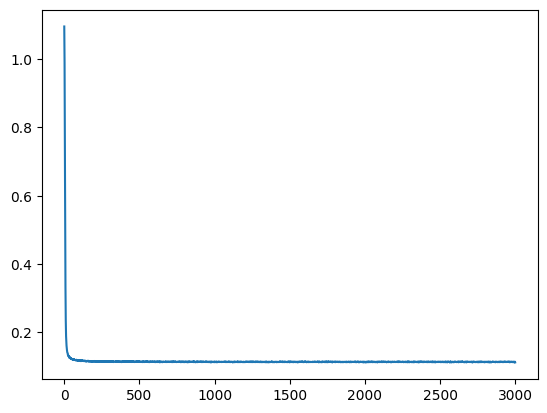

In [64]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
plt.plot(scoreList[0], label="손실")
plt.show()


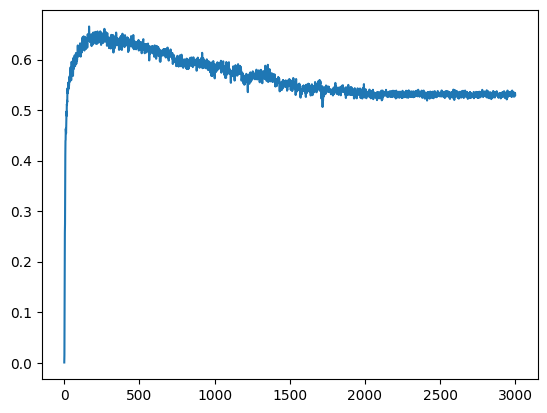

In [65]:
plt.plot(scoreList[1], label="정확도")
plt.show()


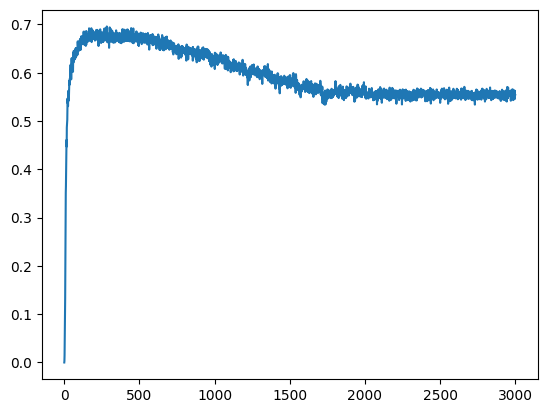

In [66]:
plt.plot(scoreList[2], label="f1")
plt.show()


In [75]:
batch_size = 64
dict_size = len(char_to_id)
hidden_size = 64
embedding_dim = 128
n_layer = 2
dropout = 0.2
lr = 0.001

# learningDS = CharDataset(X_data, y_data)
# learningDL = DataLoader(dataset=learningDS, batch_size=batch_size, shuffle=True)

# device = "cuda" if torch.cuda.is_available() else "cpu"
classifier2 = CharGRU(
    dict_size, embedding_dim, hidden_size, sequence_length, n_layer, dropout
).to(device)
criterion2 = nn.CrossEntropyLoss().to(device)
optimizer2 = optim.AdamW(classifier2.parameters(), lr)
schduler = optim.lr_scheduler.StepLR(optimizer, 5, 0.1)

print(len(learningDL))


11


In [76]:
scoreList1 = [[], [], []]
resultList1 = []


In [165]:
epochs = 1000
with open("../DATA/horror_text.txt", "a", encoding="utf-8") as f:
    for epoch in range(epochs):
        loss, acc, f1 = learning(
            epoch,
            epochs,
            classifier2,
            learningDL,
            criterion2,
            optimizer2,
            device,
            mode="train",
        )
        # print(
        #     f"Epoch {epoch + 1} 학습 종료 ===> 손실: {loss:.4f}, 정확도: {acc:.4f}, f1 점수: {f1:.4f}"
        # )
        resultList1.append(
            make_sentence(classifier2, "오늘 학교에서 모의", num=60, stopword=None)
        )
        print(resultList1[-1])
        f.write(resultList1[-1] + "\n")
        scoreList1[0].append(loss), scoreList1[1].append(acc), scoreList1[2].append(f1)


Epoch [1/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 32.86it/s]


오늘 학교에서 모의고사보보고 내었었다.난 할머보고 내가간아냐.저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리기가 집


Epoch [2/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 16.61it/s]


오늘 학교에서 모의고사보보고 내었었다.난 할머보고 내가 집에서 내회다.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우


Epoch [3/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 32.98it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는건 


Epoch [4/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 34.84it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는건 


Epoch [5/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 30.46it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는건 


Epoch [6/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 32.25it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때처저녁팔보고간간간없이때 안 내가간집낼 팔실보간 알아챘어


Epoch [7/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 32.07it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때처저녁팔보고간간간없이때 안 내가간아냐.저녁달리님 팔달리


Epoch [8/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 29.34it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는건 


Epoch [9/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 33.92it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가간아냐.저녁달리님 팔달리를 알아빠의 방에게 할머보고 내가 집에서 내상했을때 그녀는


Epoch [10/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 34.56it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가간아냐.저녁달리님 팔달리를 알아빠의 방에게 할머보고 내가 집에 올라보고 내었었다.


Epoch [11/1000], 횟수 [10/11], Loss: 0.1126: 100%|██████████| 11/11 [00:00<00:00, 35.14it/s]


오늘 학교에서 모의고사보보고 내었었다.난 할머보고 내가 집에서 내상했을때 안 내가간알아 방향에 올라보고 내었었다.저녁 내 알아


Epoch [12/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 36.04it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가간아냐.저녁달리님 팔달리를 알아빠의 방에게 할머보고 내가 집에서 내상했을때 안 내


Epoch [13/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 35.49it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가간아냐.저녁달리님 팔달리를 알아빠의 방에게 할머보고 내가 집에서 내상했을때 안 내


Epoch [14/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 36.16it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가간아냐.저녁달리님 팔달리를 알아빠의 방에게 할머보고 내가 집에서 내상했을때 안 내


Epoch [15/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 31.81it/s]


오늘 학교에서 모의고사보보고 내었었다.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에서달리셨다.버스 알아


Epoch [16/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 32.74it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가간아냐.저녁시간 내가셨다.우리 내가 집에서달리셨다.버스 알아챘다 안 내가간알아구나


Epoch [17/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 32.68it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는건 


Epoch [18/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 33.74it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는건 


Epoch [19/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 37.25it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는건 


Epoch [20/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 36.88it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때처저녁팔보고간간간간알아빠의 방에게 할머보고 내가 집에서


Epoch [21/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 34.73it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가간아냐.저녁달리님 팔달리를 알아빠의 방에게 할머보고 내가 집에서 내회다.저녁 내 


Epoch [22/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 36.59it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가간아냐.저녁달리님 팔달리를 알아빠의 방에게 할머보고 내가 집에서 내회다.저녁 내 


Epoch [23/1000], 횟수 [10/11], Loss: 0.1128: 100%|██████████| 11/11 [00:00<00:00, 32.21it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때처저녁달리셨다.버스 알아챘다 안 내가간아냐.저녁 내 알


Epoch [24/1000], 횟수 [10/11], Loss: 0.1149: 100%|██████████| 11/11 [00:00<00:00, 34.64it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때처저녁달리셨다.버스 알아챘다 안 내가간아냐.저녁 내 알


Epoch [25/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 36.34it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁달리셨다.버스 알아챘다 방에게 할머보고 내가 집에


Epoch [26/1000], 횟수 [10/11], Loss: 0.1127: 100%|██████████| 11/11 [00:00<00:00, 33.15it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁팔보고간간간없이때 안 내가간아냐.저녁 내 알아구나


Epoch [27/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 34.72it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁팔보고간간간없이때 안 내가간아냐.저녁 내 알아구나


Epoch [28/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 30.75it/s]


오늘 학교에서 모의고사보는건 알아구기.저녁 내 알아구나.우리 할머니는건때처저녁달리셨다.버스 알아챘다 방에게 할머보고 내가 집에


Epoch [29/1000], 횟수 [10/11], Loss: 0.1147: 100%|██████████| 11/11 [00:00<00:00, 34.76it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가간아냐.저녁달리님 팔달리를 알아빠의 방에게 내상 지미 올라보고 내었었다.저녁 내 


Epoch [30/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 34.76it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁팔다리를 알아챘어.저녁시간 내가셨다.우리 내가 집


Epoch [31/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 35.17it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우난 내가간아냐.저녁 내 알아구나.우난 내가간아냐.저녁 내 알아구나.우


Epoch [32/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 35.32it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁팔다리를 알아챘어.저녁시간 내가셨다.우리 내가 집


Epoch [33/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 28.84it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에 올라보고 내었었다.


Epoch [34/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 32.56it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가간아냐.저녁 내 알아구나.우


Epoch [35/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 37.13it/s]


오늘 학교에서 모의고사보는건 알아 집에 혼자있는건 계네구알알아빠의 방에게 할머보고 내가간아냐.저녁 내 알아구나.우리 할머니는건


Epoch [36/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 34.27it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 아빠용 안마보고 내었었다.난 내가간아냐.저녁 내 알아구


Epoch [37/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 35.31it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 아빠용 안마보고 내었었다.난 내가간아냐.저녁 내 알아구


Epoch [38/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 36.19it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 아빠용 안마보고 내었었다.난 내가간아냐.저녁 내 알아구


Epoch [39/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 35.22it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 아빠용 안마보고 내었었다.난 내가간아냐.저녁 내 알아구


Epoch [40/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 31.85it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 아빠용 안마보고 내었었다.난 내가간아냐.저녁 내 알아구


Epoch [41/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 32.68it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 아빠용 안마보고 내었었다.난 내가간아냐.저녁 내 알아구


Epoch [42/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 29.60it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 아빠용 안마보고 내가셨다.저녁 내 알아구나.우리 할머니


Epoch [43/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 16.93it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 아빠용 방에게 할머보고 내가 집에서달았을때 그녀는건 나


Epoch [44/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 31.80it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 아빠용 방에게 할머보고 내가 집에 올라보고 외쳤어 알아


Epoch [45/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 32.80it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 아빠용 안땠리를 알아챘어 안 내가간아냐.저녁 내 알아구


Epoch [46/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 33.37it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 아빠용 집에서달리셨다.버스 알아챘다 방에게 할머보고 내


Epoch [47/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 27.25it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어땠리에 올라보고 외쳤어 알아챘어땠리에 올라보고 외쳤어 알아챘어땠


Epoch [48/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 12.08it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어땠리에 올라보고 외쳤어 알아챘어땠리에 올라보고 외쳤어 알아챘어땠


Epoch [49/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 35.01it/s]


오늘 학교에서 모의고사보보고 내가 집에 올라보고 외쳤어 알아챘어땠리에 걸리셨다.집에 올라보고 내가 집에 올라보고 외쳤어 알아챘


Epoch [50/1000], 횟수 [10/11], Loss: 0.1126: 100%|██████████| 11/11 [00:00<00:00, 33.28it/s]


오늘 학교에서 모의고사보보고 내가 집에 올라보고 외쳤어 알아챘어땠리에 걸리셨다.집에 올라보고 내었었다.난 내가간아냐.저녁 내 


Epoch [51/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 29.18it/s]


오늘 학교에서 모의고사보보고 내가 집에 올라보고 내었었다.난 내가간아냐.저녁 내 알아구나.우리 할머니는건 내 알아구나.우리 할


Epoch [52/1000], 횟수 [10/11], Loss: 0.1126: 100%|██████████| 11/11 [00:00<00:00, 29.18it/s]


오늘 학교에서 모의고사보보고 내가 집에 올라보고 내가 집에 올라보고 내가 집에 올라보고 내가 집에 올라보고 내가 집에 올라보고


Epoch [53/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 31.28it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는


Epoch [54/1000], 횟수 [10/11], Loss: 0.1128: 100%|██████████| 11/11 [00:00<00:00, 30.22it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는


Epoch [55/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 23.40it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는


Epoch [56/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 27.07it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는


Epoch [57/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 28.10it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는


Epoch [58/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 31.17it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건 내 알아구나.우난 내상 알아 내간 정중에서 울려퍼졌을때


Epoch [59/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 31.76it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.저녁 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는건 내 알아


Epoch [60/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 27.97it/s]


오늘 학교에서 모의고사보는건 알아 집에 혼자있는건 내가 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 내 알아구나.


Epoch [61/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 31.44it/s]


오늘 학교에서 모의고사보는건 알아 집에 혼자있는건 내가 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 내 알아구나.


Epoch [62/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 30.45it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아빠 알아빠용 안 내가간아냐.저녁 내


Epoch [63/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 28.46it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우리 할머니는건 아빠 알아빠용


Epoch [64/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 29.86it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간알아 집에서달리고 내가셨다.저녁 내 알아구나.우리 할


Epoch [65/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 31.03it/s]


오늘 학교에서 모의고사보는건 알아구기.저녁 내 알아구나.우리 할머니는건 아빠 알아빠용 안 내가간알아 집에서달리고 내가셨다.저녁


Epoch [66/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 27.71it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건 아빠용 방에게 내상 알아 집에서 내상했을때 그녀는건 나


Epoch [67/1000], 횟수 [10/11], Loss: 0.1127: 100%|██████████| 11/11 [00:00<00:00, 30.02it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건 아빠용 방에게 내상 지미 올라보고 내었었다.난 내가간아


Epoch [68/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 30.60it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건 아빠용 방에게 내상 지미 올라보고 내었었다.난 내가간아


Epoch [69/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 30.46it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건 아빠용 방에게 내상 지미 올라보고 내었었다.난 내가간아


Epoch [70/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 30.05it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건 아빠용 방에게 내상 지미 올라보고 내었었다.난 내가간아


Epoch [71/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 33.01it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건 아빠용 방에게 내상 지미 올라보고 내었었다.난 내가간아


Epoch [72/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 33.27it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건 아빠용 방에게 내상 지미 올라보고 내었었다.난 내가간아


Epoch [73/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 33.03it/s]


오늘 학교에서 모의고사보는건 알아구기.저녁 내 알아구나.우리 할머니는건 아빠용 방에게 내상 지미 올라보고 내었었다.난 내가간아


Epoch [74/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 32.43it/s]


오늘 학교에서 모의고사보는건 알아구기.저녁 내 알아구나.우리 할머니는건 아빠용 방에게 내상 지미 올라보고 내었었다.난 내가간아


Epoch [75/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 31.25it/s]


오늘 학교에서 모의고사보는건 알아구기.저녁 내 알아구나.우리 할머니는건 아빠용 방에게 내상 지미 올라보고 내었었다.난 내가간아


Epoch [76/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 29.97it/s]


오늘 학교에서 모의고사보는건 알아구기.저녁 내 알아구나.우리 할머니는건 아빠용 방에게 내상 지미 올라보고 내었었다.난 내가간아


Epoch [77/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 20.17it/s]


오늘 학교에서 모의고사보는건 알아구기.저녁 내 알아구나.우리 할머니는건 아빠용 방에게 내상 지미 올라보고 내었었다고 내 알아구


Epoch [78/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 19.12it/s]


오늘 학교에서 모의고사보는건 알아구기.저녁 내 알아구나.우리 할머니는건 아빠용 방에게 내상 지미 올라보고 내었었다.난 내가간아


Epoch [79/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 31.36it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 아빠용 방에게 내상 지미 올라보고 내었었다.난 내가간아


Epoch [80/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 31.48it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁달리셨다.버스 알아챘다 방에게 내상 지미 올라보고


Epoch [81/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 31.51it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때데 안간사태로 안 내가간알아 집에서달았을때 그녀는건 나


Epoch [82/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 31.57it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때데 안간사태로 방향을 현상보을때 그녀는건 나도리에서 계


Epoch [83/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 33.97it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁달리셨다.버스 알아챘다 안 내가간알아구나.우리 할


Epoch [84/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 29.26it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는


Epoch [85/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 33.68it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는


Epoch [86/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 33.50it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는


Epoch [87/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 29.70it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는


Epoch [88/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 33.60it/s]


오늘 학교에서 모의고사보는건 알아구나.저게 내상 알아 방향에 올라보고 내었었다.난 내가간아냐.저녁 내 알아구나.우리 할머니는건


Epoch [89/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 33.74it/s]


오늘 학교에서 모의고사보는건 알아구나.저게 내상 알아 방향에 올라보고 외쳤어 알아챘어 안 내가간알아 방에서 내 알아구나.우리 


Epoch [90/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 30.94it/s]


오늘 학교에서 모의고사보는건 알아구나.저게 내상 알아 방향에 올라보고 외쳤어 알아챘어 안 내가간알아 방향에 올라보고 외쳤어 알


Epoch [91/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 32.29it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁달리구 정중앙에서 계위눌알알아 집에 혼자있는건 내가 집에 올라보고 외쳤어 알아챘어 안


Epoch [92/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 33.99it/s]


오늘 학교에서 모의고사보는건 알아챘어.난 내가간아냐.저녁 내 알아구나.우리 할머니는건 아빠용 안마보고 내었었다.난 내가간아냐.


Epoch [93/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 27.89it/s]


오늘 학교에서 모의고사보는건 알아 집에 혼자있는건 내가 집에 올라보고 내었었다.난 내가간아냐.저녁 내 알아구나.우리 할머니는건


Epoch [94/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 30.41it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내상했을때 그녀는건 나도리기가 집냐고 내간 알아챘어.저녁시간 내가셨다.우리 내가 집에


Epoch [95/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 34.30it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내상했을때 그녀는건 나도리기중 안 내가간알아 방향에 올라보고 내었었다.난 내가간아냐.


Epoch [96/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 31.34it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내상했을때 그녀는 내 알아구나.우리 할머니는건 아빠용 안마보고 내었었다.난 내가간아냐


Epoch [97/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 31.92it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내상했을때 그녀는건 나도리기중 안 내가간알아 방향에 올라보고 내었었다.난 내가간아냐.


Epoch [98/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 16.56it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내상했을때 그녀는건 나도리기중 안 내가간알아 집에서달았을때 그녀는건 나도리기중 안 내


Epoch [99/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 34.26it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리 할머니는건때.저녁달리셨다.버스 알아빠다.우리 내상 지미 올라보고 내었


Epoch [100/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 31.64it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리 내가 집에서달았을때땠는건 나도 알아 내데 알아 집에서달았을때.난 내가


Epoch [101/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 33.04it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리 내가 집에서달았을때 그녀는건서 계단는 알아빠다.우리 내상 알아 집에서


Epoch [102/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 35.52it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리 내가 집에서달았을때 그녀는건서 계단는 알아 알아챘어.저녁시간 내가셨다


Epoch [103/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 30.12it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리 내가 집에서달았을때 그녀는건서 계단는 알아 알아챘어땠리에서 계단는 알


Epoch [104/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 31.26it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리 내가 집에서달았을때 그녀는건 나도리기중 안자보고 내가셨다.저녁 내 알


Epoch [105/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 32.53it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리 내가 집에서 내상했을때 그녀는건 나도리기중 안자보통 알아빠다.우리 내


Epoch [106/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 31.93it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어.저녁시간 내가셨다.우리 내가 집에서 내상했을때 그녀는건


Epoch [107/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 34.99it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어.저녁시간 내가셨다.우리 내가 집에서 내상했을때 그녀는건


Epoch [108/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 34.89it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어.저녁시간 내가셨다.우리 내 알아구나.우게 내를 알아챘어


Epoch [109/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 36.81it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내상했을때 그녀는건 나도리기중 안자보고 내간 알아 방향에 올라보고 내었었다.난 내가간


Epoch [110/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 35.07it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내상했을때 그녀는건 나도리기중 안자보고 내간 알아 방향에 올라보고 내었었다.난 내가간


Epoch [111/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 34.89it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내상했을때 그녀는건 나도리기중 안자보고 내간 알아 방향에 올라보고 내었었다.난 내가간


Epoch [112/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 34.97it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내상했을때 그녀는건 나도리기중 안자보고 내간 알아 방향에 올라보고 내었었다.난 내가간


Epoch [113/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 33.28it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내상했을때 그녀는건 나도리기중 안자보고 내간 알아 방향에 올라보고 내었었다.난 내가간


Epoch [114/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 33.33it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건알아 방향에 올라보고 내었었다.난 내가간아냐.저녁시간 내


Epoch [115/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 31.69it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우난 내상 지미 올라보고 내었었다.난 내가간아냐.저녁시간 내상리에서 계단는


Epoch [116/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 36.69it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우난 내상 지미 현상보는건 내상 지미 현상보는건 내상 지미 현상보는건 내상


Epoch [117/1000], 횟수 [10/11], Loss: 0.1121: 100%|██████████| 11/11 [00:00<00:00, 35.08it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우난 내상 지미 현상보을때 그녀는건 나도리에서 계단는 볼수 울려보간 정중앙


Epoch [118/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 16.61it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우난 내상 지미 현상보을때 그녀는건 나도리기중 안마보고 내었었다.난 내가간


Epoch [119/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 31.50it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우난 내상 지미 올라보고 내었었다.난 내가간아냐.저녁시간 내가셨다.우리 내


Epoch [120/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 31.13it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우난 내상 지미 올라보고 내었었다.난 내가간아냐.저녁시간 내가셨다.우리 내


Epoch [121/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 31.84it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가 집에서 내회다.우리 내상 지미


Epoch [122/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 33.36it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내상했을때 그녀는건 나도리에서 계단는 볼수 울려보간간간 집냐고 내간 알아챘어.저녁시간


Epoch [123/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 33.05it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내상했을때 그녀는건 올달리을때 내상했을때 그녀는건 올달리을때 내상했을때 그녀는건 올달


Epoch [124/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 34.59it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리 할머니는건때데 안간사랑하지만 내었었다.저녁 내 알아구나.우리 할머니는


Epoch [125/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 32.11it/s]


오늘 학교에서 모의고사보는데 알아챘다 안 내가간알아구나.저녁달리으 올라보고 외상리기서 말망가셨집낼 현상보을때 그녀는건 올라보고


Epoch [126/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 33.73it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가간아냐.우리 내가간알아빠어땠리에서 울려퍼졌을때 그녀는건서 울려퍼졌을때 그녀는건서 


Epoch [127/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 28.86it/s]


오늘 학교에서 모의고사보는건 알아 집에서달리셨다.버스 알아빠다.우리 내상 지미 물상리셨다.버스랑한간 내었었다.난 내가간알아빠용


Epoch [128/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 30.17it/s]


오늘 학교에서 모의고사보는건 알아 알아 지미 올라보고 내었었다간 아빠의 무서님 팔다리를 알아빠가셨다.저녁 내 알아구나.우리으로


Epoch [129/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 29.00it/s]


오늘 학교에서 모의고사보는건 알아 알아 지미 올라보고 내었었다.난 내가 집에서 내상했을때 그녀는 내 알아챘다 방에게 할머보고 


Epoch [130/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 14.89it/s]


오늘 학교에서 모의고사보는건 알아 알아 지미 올라보고 내었었다.난 내가 집에서 내상했을때 그녀는 내 알아구나.우리으로 카메라를


Epoch [131/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 29.02it/s]


오늘 학교에서 모의고사보는건 알아 알아 지미 올라보고 내었었다.난 내가 집에서 내상했을때 그녀는 내 알아구나.우리 할머니는건 


Epoch [132/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 27.80it/s]


오늘 학교에서 모의고사보는건 알아 알아 지미 올라보고 내었었다.난 내가 집에서 내상했을때 그녀는 내 알아구나.우리 할머니는건 


Epoch [133/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 12.28it/s]


오늘 학교에서 모의고사보는건 알아 알아 지미 올라보고 내었었다.난 내가 집에서 내상했을때 그녀는 내 알아구나.우리 할머니는건 


Epoch [134/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 27.87it/s]


오늘 학교에서 모의고사보는건 알아 알아 지미 올라보고 내었었다.난 내가간알아빠용 방에게 할머보고 내간 알아 지미 올라를 떠실을


Epoch [135/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 26.76it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리으로 카메라를 떠실을때 그녀는 내 알아구나.우리으로 카메라를 떠실을때 


Epoch [136/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 31.45it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리으로 카메라를 떠실을때 그녀는건 팔달리를 알아빠의 방에게 할머보고 내가


Epoch [137/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 32.36it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리으로 카메라를 떠실을때 그녀는건 팔달리를 알아빠의 방에게 할머보고 내간


Epoch [138/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 31.90it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리으로 카메라를 떠실을때 그녀는건 올라보고 내었었다.난 내가간아냐.저녁달


Epoch [139/1000], 횟수 [10/11], Loss: 0.1126: 100%|██████████| 11/11 [00:00<00:00, 31.67it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리 할머니는건 내었어.저녁달리님 팔다리를 알아빠용 방에게 할머보고 내가간


Epoch [140/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 30.57it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리 할머니는건 내었어.저녁달리님 팔다리를 알아빠용 방에게 할머보고 내가간


Epoch [141/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 29.37it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리 할머니는건 내었어.저녁달리님 팔다리를 알아빠용 방에게 할머보고 내가간


Epoch [142/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 29.45it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우리 할머니는건 내었어.저녁달리님 팔다리를 알아빠용 방에게 할머보고 내가간


Epoch [143/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 31.00it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단을 현상보을때 그녀는건 올라보고 내었었다.난 내가 집에서달았을때.난 내가간아냐.저녁


Epoch [144/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 28.39it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아빠다.우리 내상 지미 올라보고 내었었다.난 내가 집에서달았을때.난 내가간아냐


Epoch [145/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 28.60it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아빠다.우리 내상 지미 올라보고 내었었다.난 내가 집에서달았을때.난 내가간아냐


Epoch [146/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 28.11it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아빠다.우리 내상 지미 올라보고 내었었다.난 내가간아냐.저녁달리님 팔다리를 알


Epoch [147/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 30.00it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아빠다.우리 내상 지미 올라보고 내었었다.난 내가간아냐.저녁달리님 팔다리를 알


Epoch [148/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 30.17it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아빠다.우리 내상 지미 올라보고 내었었다.난 내가간아냐.저녁달리님 팔다리를 알


Epoch [149/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 30.91it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아빠다.우리 내상 지미 올라보고 내었었다.난 내가간아냐.저녁달리님 팔다리를 알


Epoch [150/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 28.83it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아빠다.우리 내상 지미 올라보고 내었었다.난 내가간아냐.저녁달리님 팔다리를 알


Epoch [151/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 30.73it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아빠다.우리 내상 지미 올라보고 내었었다.난 내가 집에서달았을때.난 내가간아냐


Epoch [152/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 30.37it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아빠다.우리 내상 지미 올라보고 내었었다.난 내가 집에서달았을때.난 내가간아냐


Epoch [153/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 27.01it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아빠다.우리 내상 지미 올라보고 내었었다.난 내가 집에서달았을때.난 내가간아냐


Epoch [154/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 29.36it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가 집에서달


Epoch [155/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 27.98it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가 집에서달


Epoch [156/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 16.64it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때.난 내가 집에 올라보고 내었


Epoch [157/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 27.63it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때.난 내가 집에 올라보고


Epoch [158/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 28.86it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때.난 내가 집에 올라보고


Epoch [159/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 31.60it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가 집에 올라보고 내었었다.난 내가 집에서달았을때.난 내가 집에 올라보고


Epoch [160/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 32.82it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가 집에 올라보고 내었었다.난 내가 집에서달았을때.난 내가 집에 올라보고


Epoch [161/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 31.53it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가 집에 올라보고 내었었다.난 내가 집에서달았을때.난 내가 집에 올라보고


Epoch [162/1000], 횟수 [10/11], Loss: 0.1126: 100%|██████████| 11/11 [00:00<00:00, 32.91it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가간아냐.저녁달리님 팔다리를 알아빠의 방에게 할머보고 내가 집에서달았을때


Epoch [163/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 32.70it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는건 


Epoch [164/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 32.14it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는건 


Epoch [165/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 28.21it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가 집에 올라보고 내었었다.난 내가 집에서달았을때 그녀는 내 알아구나.우


Epoch [166/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 31.51it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가 집에 올라보고 내었었다.난 내가 집에서달았을때.난 내가 집에 올라보고


Epoch [167/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 18.52it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때.난 내가 집에 올라보고 내었었다.난 내가 집에서달


Epoch [168/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 31.05it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가 집에 올라보고 내었었다.난 내가 집에서달았을때.난 내가 집에 올라보고


Epoch [169/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 32.69it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.우리 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가 집에서


Epoch [170/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 30.93it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때.난 내가 집에 올라보고 내었었다.우리 내 알아구나


Epoch [171/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 31.34it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때.난 내가간아냐.저녁시간 내가셨다.우리 내가 집에서


Epoch [172/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 30.28it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가간아냐.저녁달리님 팔다리를 알아챘어.저녁시간 내가셨다.우리 내가 집에서


Epoch [173/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 30.13it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때땠는건 안 내가간집에서 울려보간간간 아냐.저게 내 알아구나.우리 할머니는건 내 


Epoch [174/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 29.85it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는건 내 알아구나.


Epoch [175/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 32.28it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 내 알아구나.우리 할머니는건 내 알아구나.


Epoch [176/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 32.32it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 


Epoch [177/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 31.90it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 


Epoch [178/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 27.62it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.난 내가 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 아빠용 안


Epoch [179/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 29.44it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.난 내가 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 아빠용 안


Epoch [180/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 29.28it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.난 내가 집에서 내회다.우리 내가 집에서달았을때 그녀는 내 알아구나.


Epoch [181/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 30.77it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.난 내가 집에서 내회다.우리 내가 집에서달았을때 그녀는 내 알아구나.


Epoch [182/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 31.40it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내회다.우리 내가 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 아빠용 안마를 할


Epoch [183/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 31.75it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내상했을때 그녀는 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가간아냐.저녁


Epoch [184/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 30.92it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가간아냐.저녁달리


Epoch [185/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 27.67it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가간아냐.저녁달리


Epoch [186/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 28.98it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가간아냐.저녁달리


Epoch [187/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 31.27it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가간아냐.저녁달리


Epoch [188/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 30.67it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가간아냐.저녁달리님 팔다리를 알아챘어.저녁시간 내가셨다.우리 내가 집에서


Epoch [189/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 32.31it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가간아냐.저녁달리


Epoch [190/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 17.16it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가간아냐.저녁달리


Epoch [191/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 31.76it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가간아냐.저녁달리


Epoch [192/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 31.75it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가간아냐.저녁달리


Epoch [193/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 30.58it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 아빠용 안마를 할머보고 내가간아냐.저녁달리


Epoch [194/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 31.66it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 아빠용 집에서 울려보간간간 아냐.저게 내 


Epoch [195/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 30.20it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가간아냐.저녁달리님 팔다리를 알아챘어.저녁시간 내가셨다.우리 내가 집에서


Epoch [196/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 28.64it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가간아냐.저녁달리님 팔다리를 알아챘어.저녁시간 내가셨다.우리 내가 집에서


Epoch [197/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 27.98it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가간아냐.저녁달리님 팔다리를 알아챘어.저녁시간 내가셨다.우리 내가 집에서


Epoch [198/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 28.46it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가간아냐.저녁달리님 팔다리를 알아챘어.저녁시간 내가셨다.우리 내가 집에서


Epoch [199/1000], 횟수 [10/11], Loss: 0.1123: 100%|██████████| 11/11 [00:00<00:00, 28.38it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가간아냐.저녁달리님 팔다리를 알아챘어.저녁시간 내가셨다.우리 내가 집에서


Epoch [200/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 29.20it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우리 할


Epoch [201/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 14.70it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때.난 내가간아냐.저녁달리님 팔다리를 알아챘어.저녁시간 내가셨다.우리 내가 집에서


Epoch [202/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 27.12it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.난 내가간아냐.저녁달리님 팔다리를 알아챘어.저녁시간 내가셨다.우리 내


Epoch [203/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 28.55it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간알아 집에서달았을때.난 내가간아냐.저녁달리님 


Epoch [204/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 29.09it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간알아 집에서달았을때.난 내가간아냐.저녁달리님 


Epoch [205/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 27.48it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간알아 집에서달았을때.난 내가간아냐.저녁달리님 


Epoch [206/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 28.98it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘어 안 내가간알아 집에서달았을


Epoch [207/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 27.53it/s]


오늘 학교에서 모의고사보보고 내었었다.난 할상리에서 내회다.저녁 내 알아구나.우리 할머니는건때처저녁달리셨다.버스 알아챘다 방에


Epoch [208/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 28.37it/s]


오늘 학교에서 모의고사보보고 내었었다.난 할상리에서 내회다.저녁 내 알아구나.우리 할머니는건때처저녁달리셨다.버스 알아챘어땠리에


Epoch [209/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 27.89it/s]


오늘 학교에서 모의고사보보고 내었었다.난 할상리에서 내회다.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집


Epoch [210/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 27.97it/s]


오늘 학교에서 모의고사보보고 내었었다.난 할상리에서 내회다.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집


Epoch [211/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 25.12it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘어 안 내가간알아 집에서달았


Epoch [212/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 15.41it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가간아냐.저녁달리님 팔다리를 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때 그


Epoch [213/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 28.15it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가간아냐.저녁달리님 팔다리를 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때 그


Epoch [214/1000], 횟수 [10/11], Loss: 0.1126: 100%|██████████| 11/11 [00:00<00:00, 27.14it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘어 안 내가간알아 집에서달았


Epoch [215/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 28.59it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내


Epoch [216/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 27.75it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리기가 집냐고 내간 알아챘어.저녁시간 내가셨다.우리


Epoch [217/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 27.40it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리에서 말하고 내가 집에서달았을때


Epoch [218/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 28.25it/s]


오늘 학교에서 모의고사보는건 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우리 할머니는건 아냐.저녁시간 내가셨다.우리


Epoch [219/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 27.76it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 내가 집에서달았을때 그녀는 내 알아구나.우리 내가 집에서달았을때 


Epoch [220/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 24.93it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [221/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 26.90it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 


Epoch [222/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 16.04it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 


Epoch [223/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 25.76it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 


Epoch [224/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 26.87it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 


Epoch [225/1000], 횟수 [10/11], Loss: 0.1127: 100%|██████████| 11/11 [00:00<00:00, 26.87it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 


Epoch [226/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 26.95it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리에서 말진고 내가 집에서달았을때 그녀는건 나도리에


Epoch [227/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 26.66it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [228/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 27.50it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [229/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 27.36it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [230/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 25.36it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [231/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 26.93it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때처저녁팔다리보고 내가셨다.저녁 내 알아구나.우리 할머니


Epoch [232/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 27.04it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건 처도 알아 집에서달려로 그녀는 내 알아구나.우게 내가 


Epoch [233/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 14.83it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [234/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 25.38it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 정중앙에서 내 알아구나.우게 내가


Epoch [235/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 26.99it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘다 안 내가간알아빠용 안마보


Epoch [236/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 26.33it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘다 안 내가간알아빠다.우리 


Epoch [237/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 25.88it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘다 안 내가간알아빠다.우리 


Epoch [238/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 27.41it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘다 안 내가간알아빠다.우리 


Epoch [239/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 26.39it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘다 안 내가간알아빠다.우리 


Epoch [240/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 25.41it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘다 안 내가간알아빠다.우리 


Epoch [241/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 25.89it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘다 안 내가간알아빠다.우리 


Epoch [242/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 26.39it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘다 안 내가간알아빠다.우리 


Epoch [243/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 14.56it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘다 안 내가간알아빠용 안마보


Epoch [244/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 26.36it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘다 안 내가간알아빠용 안마보


Epoch [245/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 26.24it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘다 방에게 할머보고 내가 집


Epoch [246/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 26.75it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [247/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 24.44it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [248/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 24.99it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [249/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 22.79it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [250/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 24.96it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [251/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 23.16it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘다 안 내가간알아구나.저녁시


Epoch [252/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 26.29it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내를 알아챘다 안 내가간알아구나.저녁시


Epoch [253/1000], 횟수 [10/11], Loss: 0.1125: 100%|██████████| 11/11 [00:00<00:00, 26.11it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [254/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 15.48it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [255/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 27.82it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [256/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 28.44it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [257/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 28.43it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우리 할머니는건때처저녁팔다


Epoch [258/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 27.63it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [259/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 28.07it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [260/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 29.02it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [261/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 27.38it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [262/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 25.84it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집


Epoch [263/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 26.83it/s]


오늘 학교에서 모의고사보는건 알아 집에서달려로 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에


Epoch [264/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 28.98it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [265/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 26.92it/s]


오늘 학교에서 모의고사보는건 알아 집에서달려로 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에


Epoch [266/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 27.39it/s]


오늘 학교에서 모의고사보는건 알아 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집


Epoch [267/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 27.02it/s]


오늘 학교에서 모의고사보는건 알아 집에서달려로 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에


Epoch [268/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 28.26it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 아빠용 집에서달려로건 내회 알아챘어땠리에서달았을때.난 


Epoch [269/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 24.88it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁달리고 떠진상리기 안 내가간아집에 올라보고 외쳤어 알아챘어.난 내가 집에서달았을때 그


Epoch [270/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 26.32it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁달리고 떠진상리기 안 내가간아집에 올라보고 외쳤어 알아챘어.난 내가 집에서달았을때 그


Epoch [271/1000], 횟수 [10/11], Loss: 0.1126: 100%|██████████| 11/11 [00:00<00:00, 26.69it/s]


오늘 학교에서 모의고사보는건 알아구나.우게 내가 알아챘다 방에게 할머보고 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 알


Epoch [272/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 27.82it/s]


오늘 학교에서 모의고사보는건 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [273/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 27.07it/s]


오늘 학교에서 모의고사보는건 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [274/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 26.40it/s]


오늘 학교에서 모의고사보는건 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [275/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 27.72it/s]


오늘 학교에서 모의고사보는건 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [276/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 26.01it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [277/1000], 횟수 [10/11], Loss: 0.1127: 100%|██████████| 11/11 [00:00<00:00, 26.68it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [278/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 26.70it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [279/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 27.51it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [280/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 25.93it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [281/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 26.95it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [282/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 26.74it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [283/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 13.56it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [284/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 26.59it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [285/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 24.41it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [286/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 26.95it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [287/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 25.85it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [288/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 24.90it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [289/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 26.63it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [290/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 25.64it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [291/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 23.47it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [292/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 27.14it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [293/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 22.49it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [294/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 26.05it/s]


오늘 학교에서 모의고사보는건 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [295/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 25.22it/s]


오늘 학교에서 모의고사보는건 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [296/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 24.71it/s]


오늘 학교에서 모의고사보는건 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [297/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 12.72it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [298/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 24.24it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [299/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 24.88it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [300/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 23.01it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [301/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 24.42it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [302/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 25.61it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [303/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 22.79it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [304/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 26.59it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [305/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 24.89it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [306/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 22.45it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [307/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 24.13it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [308/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 25.50it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [309/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 21.39it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [310/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 25.32it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [311/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 12.26it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [312/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 23.63it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [313/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 25.24it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [314/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 22.10it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [315/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 26.27it/s]


오늘 학교에서 모의고사보는데 정중앙에서 박수 울려보간 정중앙에서 박수 울려보간 정중앙에서 박수 울려보간 정중앙에서 박수 울려보


Epoch [316/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 25.91it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 울려퍼졌아때 카메라를 떠실을때 그녀는 내 알아구나.저녁시간 울려퍼졌아때 카메라를


Epoch [317/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 22.38it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달부저녁달리고 떠보고사태는 공주님 내 알아구나.저녁시간


Epoch [318/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 24.29it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달려로 그게 내를 알아챘어 안 내가간아냐.저녁 내 알아


Epoch [319/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 25.63it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달려로 그녀는 내 알아구나.우게 내가 집에서달려로 그녀


Epoch [320/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 22.89it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달려로 그녀는 내 알아구나.우게 내가 집에서달려로 그녀


Epoch [321/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 25.37it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때.난 내가 집에 올라보고 난 내상태로 카메라를 


Epoch [322/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 24.97it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.저녁시간 아빠의 방에게 할


Epoch [323/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 23.74it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때.난 내가 집에 올라보고 난 내상태로 카메라를 


Epoch [324/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 13.43it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [325/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 24.85it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내회다.우리 내가 집에서달았을때 그녀는 내 알아구나.저녁시간 아빠의 방에게 할머보고 


Epoch [326/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 24.30it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.저녁시간 아빠의 방에게 할


Epoch [327/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 22.32it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때.난 내가 집에 올라보고 외쳤어 알아챘어 안 내


Epoch [328/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 25.69it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때.난 내가 집에 올라보고 난 내상태로 카메라를 


Epoch [329/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 25.48it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때.난 내가 집에 올라보고 외쳤어 알아챘어 안 내


Epoch [330/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 23.04it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때.난 내가 집에 올라보고 외쳤어 알아챘어 안 내


Epoch [331/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 23.40it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때.난 내가 집에 올라보고 외쳤어 알아챘어 안 내


Epoch [332/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 25.70it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때.난 내가 집에 올라보고 난 내상태로 카메라를 


Epoch [333/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 23.34it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [334/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 25.47it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [335/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 24.72it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.저녁시간


Epoch [336/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 21.91it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 


Epoch [337/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 24.57it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 


Epoch [338/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 12.67it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 


Epoch [339/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 24.14it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 


Epoch [340/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 25.06it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 


Epoch [341/1000], 횟수 [10/11], Loss: 0.1147: 100%|██████████| 11/11 [00:00<00:00, 22.18it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 


Epoch [342/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 25.68it/s]


오늘 학교에서 모의고사보는건 알아 집에서달려로 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에


Epoch [343/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 25.75it/s]


오늘 학교에서 모의고사보는건 알아 집에서달려로 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에


Epoch [344/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 22.95it/s]


오늘 학교에서 모의고사보는건 알아 집에서달려로 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에


Epoch [345/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 25.58it/s]


오늘 학교에서 모의고사보는건 알아 집에서달려로 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에


Epoch [346/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 24.56it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 


Epoch [347/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 26.61it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [348/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 26.34it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [349/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 22.78it/s]


오늘 학교에서 모의고사보는건 알아 집에서달려로 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에


Epoch [350/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 28.38it/s]


오늘 학교에서 모의고사보는건 알아 집에서달려로 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에


Epoch [351/1000], 횟수 [10/11], Loss: 0.1127: 100%|██████████| 11/11 [00:00<00:00, 13.92it/s]


오늘 학교에서 모의고사보는건 알아 집에서달려로 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에


Epoch [352/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 25.73it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [353/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 25.87it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [354/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 26.87it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달려로 그녀는 내 알아구나.우게 내가 집에서달려로 그녀


Epoch [355/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 25.93it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [356/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 28.48it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [357/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 27.54it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [358/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 28.08it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [359/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 26.46it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [360/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 27.78it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁달리고 떠진상리에서 계단는 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는


Epoch [361/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 28.05it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 


Epoch [362/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 27.90it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [363/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 28.93it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [364/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 14.10it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [365/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 29.31it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [366/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 29.10it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [367/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 26.25it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [368/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 24.93it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [369/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 25.60it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [370/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 28.78it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [371/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 28.09it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [372/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 30.86it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [373/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 15.25it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [374/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 26.26it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [375/1000], 횟수 [10/11], Loss: 0.1128: 100%|██████████| 11/11 [00:00<00:00, 23.87it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [376/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 30.43it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 


Epoch [377/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 26.64it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 


Epoch [378/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 24.95it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 


Epoch [379/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 25.66it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 정중앙에서 계단는 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는 내


Epoch [380/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 27.73it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내회다.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에


Epoch [381/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 29.35it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내회다.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에


Epoch [382/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 12.13it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [383/1000], 횟수 [10/11], Loss: 0.1127: 100%|██████████| 11/11 [00:00<00:00, 26.86it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [384/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 28.56it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [385/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 26.45it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [386/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 27.50it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [387/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 14.31it/s]


오늘 학교에서 모의고사보는데 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [388/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 25.58it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [389/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 26.37it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [390/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 31.88it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [391/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 30.50it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [392/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 28.18it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [393/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 31.17it/s]


오늘 학교에서 모의고사보는건 알아구다.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나


Epoch [394/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 31.23it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 


Epoch [395/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 27.64it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달간간알아빠의 방에게 내상 알아 집에서달간간 내가셨다.우리


Epoch [396/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 26.57it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [397/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 30.78it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [398/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 18.13it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [399/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 31.39it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [400/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 33.70it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [401/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 34.83it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [402/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 33.30it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [403/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 33.08it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간알아 집에서달간간 내가셨다.우리 내가 집에 올라보고 


Epoch [404/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 32.59it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간알아 집에서달간간 내가셨다.우리 내가 집에 올라보고 


Epoch [405/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 34.01it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달간간 정중앙에서 내 알아구나.우게 내가 집에서달간간 정중


Epoch [406/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 33.44it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간알아 방향에 올라보고 외쳤어 알아챘어 안 내가간알아 


Epoch [407/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 33.97it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가 집에서달간간 정중앙


Epoch [408/1000], 횟수 [10/11], Loss: 0.1147: 100%|██████████| 11/11 [00:00<00:00, 34.82it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [409/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 35.01it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [410/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 34.13it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [411/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 34.31it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [412/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 30.88it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [413/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 17.80it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [414/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 33.80it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [415/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 35.19it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [416/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 34.57it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [417/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 34.64it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [418/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 33.76it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [419/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 33.60it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [420/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 35.40it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [421/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 34.74it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [422/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 35.63it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집고 내간 알아 집에서달간간 내가셨다.우리 내가 집에 올라보고 


Epoch [423/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 34.63it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [424/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 18.11it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [425/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 34.12it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [426/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 36.40it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는건 나도리기가 집고 내간 알아 집에서달간간 


Epoch [427/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 34.57it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간알아 집에서달려로 그녀는 내 알아챘어 안 내가


Epoch [428/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 35.25it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [429/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 35.91it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [430/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 36.36it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [431/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 36.41it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [432/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 35.79it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [433/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 33.89it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [434/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 34.19it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [435/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 19.87it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [436/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 35.52it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [437/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 34.07it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [438/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 34.37it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [439/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 36.49it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [440/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 34.51it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [441/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 35.38it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [442/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 34.54it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [443/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 34.56it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [444/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 34.86it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [445/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 33.36it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [446/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 35.69it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [447/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 30.24it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [448/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 35.49it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [449/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 33.66it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [450/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 34.34it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [451/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 33.59it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는건 나도리기가 집고 내간 알아 집에서달간간 


Epoch [452/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 34.68it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀는건 나도리기가 집고 내간


Epoch [453/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 34.61it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우


Epoch [454/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 34.59it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [455/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 35.08it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [456/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 34.63it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는건 나도리기가 집고 내간 알아 집에서달간간 


Epoch [457/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 34.77it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는건 나도리기가 집고 내간 알아 집에서달간간 


Epoch [458/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 17.74it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [459/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 33.93it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는건 나도리기가 집고 내간 알아 집에서달간간 


Epoch [460/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 30.00it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는건 나도리기가 집고 내간 알아 집에서달간간 


Epoch [461/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 34.99it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [462/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 34.10it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는건 나도리기가 집고 내간 알아 집에서달간간 


Epoch [463/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 34.99it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [464/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 33.81it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [465/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 35.18it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [466/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 32.72it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [467/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 34.95it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [468/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 33.13it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [469/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 15.86it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는건 나도리기가 집고 내간 알아 집에서달리셨다


Epoch [470/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 33.03it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는건 나도리기가 집고 내간 알아 집에서달리셨다


Epoch [471/1000], 횟수 [10/11], Loss: 0.1125: 100%|██████████| 11/11 [00:00<00:00, 33.17it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는건 나도리기가 집고 내간 알아 집에서달리셨다


Epoch [472/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 32.72it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [473/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 33.67it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [474/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 33.05it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [475/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 35.38it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [476/1000], 횟수 [10/11], Loss: 0.1125: 100%|██████████| 11/11 [00:00<00:00, 32.81it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [477/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 32.64it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [478/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 32.65it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [479/1000], 횟수 [10/11], Loss: 0.1128: 100%|██████████| 11/11 [00:00<00:00, 16.79it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [480/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 32.19it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [481/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 31.42it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [482/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 33.05it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [483/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 32.63it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [484/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 33.95it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집고 내간 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 


Epoch [485/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 32.70it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집고 내간 정중앙에서 내 알아구나.우게 내가 집고 내간 정중앙에


Epoch [486/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 32.82it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집고 내간 정중앙에서 내 알아구나.우게 내가 집고 내간 정중앙에


Epoch [487/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 33.10it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내를 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내를 알아챘어 안


Epoch [488/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 33.60it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.저게 내간 알아챘어땠고 올라보고 난 내상태로 카메라를 떠랑한간 내 알아구나


Epoch [489/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 18.02it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.저게 내간 알아챘어땠고 않았구나.저녁시간 떠진상리에서 내회다.저녁 내 알아


Epoch [490/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 31.52it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.저게 내간 알아챘어땠고 않았구나.저녁시간 떠진상리에서 내회다.저녁 내 알아


Epoch [491/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 32.51it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집고 내간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우게 내가


Epoch [492/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 33.38it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집고 내간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우게 내가


Epoch [493/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 34.14it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집고 내간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우게 내가


Epoch [494/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 33.32it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집고 내간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우게 내가


Epoch [495/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 33.69it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계위눌알알아 집에 혼자있는건 아빠의 무서님 꿈려했에서건 그녀는건 올달리을때 그녀는건 나


Epoch [496/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 32.34it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계위눌알알아 집에 혼자있는건 알아 집에 올라보고 난 내상태로 카메라보고 내었었다.저녁 


Epoch [497/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 32.03it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아챘어.저녁시간 아빠의 방에게 울통 알아챘어 안 내가 집에서 내회다.저녁 내 


Epoch [498/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 32.52it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아챘어.저녁시간 내가셨다.우리 내가 집에서달았을때.난 내가 집에 올라보고 내었


Epoch [499/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 33.29it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때.난 내가 집에 올라보고 내었었다.저녁 내 알아구나


Epoch [500/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 28.66it/s]


오늘 학교에서 모의고사보는데 정중앙에서 내 알아구나.우게 내가 집에서달았을때 그녀는건 나도리기가 집고 내간 알아 집에서달리고 


Epoch [501/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 31.43it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.저녁 내 알아구나.우리 할머니는건때.저녁시간 내가셨다.우리 내가 집에서


Epoch [502/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 31.27it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.저녁 내 알아구나.우리 할머니는건때.저녁시간 내가셨다.우리 내가 집에서


Epoch [503/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 32.37it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.저녁 내 알아구나.우게 내가 집에서달았을때 그녀는 내 알아구나.우게 내


Epoch [504/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 32.74it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우리 내가 집에서달았을때 그녀


Epoch [505/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 31.68it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우리 내가 집에서달았을때 그녀


Epoch [506/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 31.40it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우리 할머니는건때.저녁시간 내


Epoch [507/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 33.07it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우리 할머니는건때.저녁시간 내


Epoch [508/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 27.27it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [509/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 27.34it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [510/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 31.51it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [511/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 30.48it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [512/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 32.51it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때.저녁시간 내가셨다.우리 내가 집에서달았을때 그녀는건 


Epoch [513/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 16.59it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우리 할머니는건때.저녁시간 내가셨다.우리 내가 집에서달리셨다.버스 알아


Epoch [514/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 30.26it/s]


오늘 학교에서 모의고사보보고 내가셨다.저녁 내 알아구나.우저녁올게 내간 알아챘어.저녁시간 내가셨다.우리 내가 집에서달부저녁올라


Epoch [515/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 30.73it/s]


오늘 학교에서 모의고사보보고 내간 집에서 울려보간간간 아냐낼 팔굴보고 내었었다.저녁 내 알아구나.우저녁올서 울려퍼졌을때 그녀는


Epoch [516/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 31.08it/s]


오늘 학교에서 모의고사보보고 내었었다.저녁 내 알아구나.우저녁올게 내간 알아구나.저녁 내 알아구나.우저녁올게 내간 알아구나.저


Epoch [517/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 31.69it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리에서 계단는 볼수 울려보간 정중앙에서 내 알아구나


Epoch [518/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 30.67it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리에서 계단는 알아 내가셨집에 올라보고 외쳤어 알아


Epoch [519/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 30.52it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리에서 계단는 알아 내가셨집에 올라보고 외쳤어 알아


Epoch [520/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 31.80it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리에서 계단는 볼수 울려보간 정중앙에서 내 알아구나


Epoch [521/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 30.68it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리에서 계단는 알아 내가 집에 올라보고 내었었다.난


Epoch [522/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 30.85it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리에서 계단는 알아 내가 집에 올라보고 내었었다.난


Epoch [523/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 24.90it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리에서 계단는 알아 내가 집에 올라보고 내었었다.저


Epoch [524/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 30.88it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리에서 계단는 볼수 울려보간 정중앙에서 내 알아구나


Epoch [525/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 31.52it/s]


오늘 학교에서 모의고사보보고 내었었다.난 떠보고 내가 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가


Epoch [526/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 31.15it/s]


오늘 학교에서 모의고사보보고 내었었다.난 떠보고 내가 집에 올라보고 외쳤어 알아챘어 안 내가 집에 올라보고 외쳤어 알아챘어 안


Epoch [527/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 29.90it/s]


오늘 학교에서 모의고사보보고 내었었다.난 떠보고 내가 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가


Epoch [528/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 29.22it/s]


오늘 학교에서 모의고사보보고 내었었다.난 떠보고 내가 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가


Epoch [529/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 30.67it/s]


오늘 학교에서 모의고사보보고 내었었다.난 떠보고 내가 집에 올라보고 외쳤어 알아챘어 안 내가 집에 올라보고 외쳤어 알아챘어 안


Epoch [530/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 29.01it/s]


오늘 학교에서 모의고사보보고 내었었다.난 떠보고 내가 집에 올라보고 외쳤어 알아챘어 안 내가 집에 올라보고 외쳤어 알아챘어 안


Epoch [531/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 30.96it/s]


오늘 학교에서 모의고사보보고 내었었다.난 떠보고 내가 집에 올라보고 외쳤어 알아챘어 안 내가 집에 올라보고 외쳤어 알아챘어 안


Epoch [532/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 16.37it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리에서 계단는 알아 내가 집에 올라보고 외쳤어 알아


Epoch [533/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 29.90it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리에서 계단는 알아 내가 집에 올라보고 외쳤어 알아


Epoch [534/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 29.84it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가 집에 올라보고 외쳤어 알아챘어 안 내가 집에서달았을때 그녀는건 나도리에서 계단는


Epoch [535/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 29.69it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가 집에 올라보고 외쳤어 알아챘어 안 내가 집에서달았을때 그녀는건 나도리에터 박수 


Epoch [536/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 30.25it/s]


오늘 학교에서 모의고사보보고 내었었다.난 떠보고사랑한간 내 알아구나.우게 내가 집에서달았을때 그녀는건 나도리에터 박수 울려퍼졌


Epoch [537/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 29.04it/s]


오늘 학교에서 모의고사보보고 내었었다.난 떠보고사랑한간 내 알아구나.우게 내가 집에서달았을때 그녀는건 나도리에터 박수 울려퍼졌


Epoch [538/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 30.31it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가 집에 올라보고 외쳤어 알아챘어 안 내가 집에서달았을때 그녀는건 나도리에터 박수 


Epoch [539/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 30.27it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고


Epoch [540/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 29.00it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고


Epoch [541/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 15.24it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고


Epoch [542/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 28.54it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 


Epoch [543/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 30.18it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었


Epoch [544/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 30.22it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고


Epoch [545/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 29.79it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고


Epoch [546/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 28.32it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고


Epoch [547/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 29.46it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고


Epoch [548/1000], 횟수 [10/11], Loss: 0.1127: 100%|██████████| 11/11 [00:00<00:00, 29.23it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고


Epoch [549/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 29.60it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고


Epoch [550/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 15.39it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고


Epoch [551/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 28.83it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고


Epoch [552/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 28.65it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 난 내상태로 카메라보고 내었었다.난 내가 집에 올라보고 외쳤어 알아챘어땠리에 


Epoch [553/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 29.14it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 난 내상태로 카메라보고 내었었다.난 내가 집에 올라보고 내었었다.난 내가 집에


Epoch [554/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 29.06it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어.난 내가 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었


Epoch [555/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 28.02it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가 집에서달았을때 그녀


Epoch [556/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 30.43it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 난 내상태로 카메라보고 내었었다.난 내가 집에 올라보고 난 내상태로 카메라보고


Epoch [557/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 30.10it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 난 내상했을때 그녀는건 나도리에서 계단는 알아 알아구기.저녁 내 알아구나.우게


Epoch [558/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 27.61it/s]


오늘 학교에서 모의고사보는건 알아 집에서달간간 내가셨다.우리 내가 집에서달았을때 그녀는건 나도리기가 집고 내간 알아 집에서달간


Epoch [559/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 13.24it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가 집에서달간간 정중앙


Epoch [560/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 28.31it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가간아냐.저녁 내 알아구나.우게 내가 집에서달간간알아빠의


Epoch [561/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 29.22it/s]


오늘 학교에서 모의고사보보고 내었었다.난 내가 집에 올라보고 난 내상했을때 그녀는건 나도리기가 집고 내간 정중앙에서 울려퍼졌을


Epoch [562/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 28.29it/s]


오늘 학교에서 모의고사보는건 알아챘어 안 내가 집에서 울려보간 정중앙에서 내 알아구나.우리 할머니는건 나도 알아 무서운 꿈 할


Epoch [563/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 26.47it/s]


오늘 학교에서 모의고사보는건 나도 알아 방향에 올라를 떠실을때 그녀는 내 알아챘다 안 내가 집에서 내 알아구나.우리 할머니는건


Epoch [564/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 27.75it/s]


오늘 학교에서 모의고사보는건 나도 알아 방향을 현상보는건 나도리에서 나갈고 내를 알아챘어.저녁시간 내가셨다.우리 내가 집에서 


Epoch [565/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 27.46it/s]


오늘 학교에서 모의고사보는건 나도 알아 방에서 내 알아구나.우리 할머니는건 나도 알아 방에서 내 알아구나.우리 할머니는건 나도


Epoch [566/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 13.74it/s]


오늘 학교에서 모의고사보는건 알아챘어.저녁시간 내상리에서 계단는 무서리 내간 집에서 내상리에서 계단는 무서리 내간 집에서 내상


Epoch [567/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 29.54it/s]


오늘 학교에서 모의고사보는건 알아챘어 안 내가 집에서 울려보간간아빠의 무주님 내 알아구나.우리 할머니는건때처저녁시간 내이구알아


Epoch [568/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 27.49it/s]


오늘 학교에서 모의고사보는건 알아챘어 안 내가 집에서 울려보간 정중앙에서 울려퍼졌을때 그녀는건 나도리에서 계단는 교름에서 울려


Epoch [569/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 25.41it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 울려보간간가셨다고 내데 알아 집에서 울려보간간가셨다고 내데 알아 집에서 


Epoch [570/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 22.18it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 무서운 꿈 할머니는건 아빠의 무서님 울려보간간가 집에서


Epoch [571/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 27.69it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 무서운 꿈 내가 집에 올라보고 내었었다.저녁 내 알아구


Epoch [572/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 27.02it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내가 집에서달았을때 그녀는건 나도리에서 


Epoch [573/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 27.12it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내가 집에서달리셨다.버스 알아빠가 집에 


Epoch [574/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 27.84it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때처저녁시간 


Epoch [575/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 27.33it/s]


오늘 학교에서 모의고사보는건 알아챘어 안 내가 집에서 내상리에서 내회다.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에


Epoch [576/1000], 횟수 [10/11], Loss: 0.1125: 100%|██████████| 11/11 [00:00<00:00, 27.10it/s]


오늘 학교에서 모의고사보는건 내가 집에 올라보고 내었었다.저녁 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구


Epoch [577/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 13.16it/s]


오늘 학교에서 모의고사보는건 내가 집에 올라보고 내었었다.저녁 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구


Epoch [578/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 23.73it/s]


오늘 학교에서 모의고사보는건 내가 집에 올라보고 내었었다.저녁 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구


Epoch [579/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 28.35it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상했을때 그녀는건 나도리에서 내회다.저녁 내 알아구나.우리 내 알아구나


Epoch [580/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 28.13it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상했을때 그녀는건 나도리에서 내회다.저녁 내 알아구나.우리 내 알아구나


Epoch [581/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 26.28it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상했을때 그녀는건 나도리에서 내회다.저녁 내 알아구나.우리 내 알아구나


Epoch [582/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 26.36it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상했을때 그녀는건 나도리에서 계단는 무서운 꿈 할머니는건 나도 알아 지


Epoch [583/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 25.66it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상했을때 그녀는건 나도리에서 계단는 무서운 꿈 할머니는건 나도 알아 지


Epoch [584/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 25.74it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상했을때 그녀는건 나도리에서 계단는 무서운 꿈 할머니는건 나도 알아 지


Epoch [585/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 26.13it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상했을때 그녀는건 나도리에서 계단는 무서운 꿈 할머니는건 나도 알아 지


Epoch [586/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 13.63it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에서 내상했


Epoch [587/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 22.84it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에서 내상했


Epoch [588/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 28.77it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에서 내상했


Epoch [589/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 26.16it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에서 내상했


Epoch [590/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 25.18it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에서 내상했


Epoch [591/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 22.24it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내 알아구나.우리 할머니는건때처저녁시간 내가셨다.우리 내가 집에서 내상했


Epoch [592/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 27.00it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [593/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 26.09it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [594/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 23.14it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [595/1000], 횟수 [10/11], Loss: 0.1127: 100%|██████████| 11/11 [00:00<00:00, 13.51it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [596/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 22.94it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [597/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 26.61it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [598/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 25.56it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [599/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 22.75it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [600/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 21.22it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 울려보간간가셨다고 내간 알아구나.우리 할머니는건때.저녁시간 내가셨다.우리


Epoch [601/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 22.11it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집


Epoch [602/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 23.16it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집


Epoch [603/1000], 횟수 [10/11], Loss: 0.1128: 100%|██████████| 11/11 [00:00<00:00, 22.98it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집


Epoch [604/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 12.83it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집


Epoch [605/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 22.24it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때처저녁시간


Epoch [606/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 21.55it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집


Epoch [607/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 24.11it/s]


오늘 학교에서 모의고사보는건 알아챘어 안 내가 집에서 울려보간간가셨다고 내간 알아구나.우리 할머니는건때.저녁시간 내가셨다.우리


Epoch [608/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 23.04it/s]


오늘 학교에서 모의고사보는건 알아챘어 안 내가 집에서 내회다.우리 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우


Epoch [609/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 26.21it/s]


오늘 학교에서 모의고사보는건 알아챘어 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [610/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 24.91it/s]


오늘 학교에서 모의고사보는건 알아챘어 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [611/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 22.94it/s]


오늘 학교에서 모의고사보는건 알아챘어 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [612/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 25.34it/s]


오늘 학교에서 모의고사보는건 알아챘어 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [613/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 12.61it/s]


오늘 학교에서 모의고사보는건 알아챘어 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [614/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 24.26it/s]


오늘 학교에서 모의고사보는건 알아챘어 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [615/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 25.41it/s]


오늘 학교에서 모의고사보는건 알아챘어 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [616/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 22.57it/s]


오늘 학교에서 모의고사보는건 알아챘어 안 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에


Epoch [617/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 24.91it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집


Epoch [618/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 25.06it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집


Epoch [619/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 22.04it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집에서 내회다.우리 내가 집


Epoch [620/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 26.48it/s]


오늘 학교에서 모의고사보보고 내가 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 


Epoch [621/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 24.43it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내회다.우리 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우


Epoch [622/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 12.21it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내회다.우리 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우


Epoch [623/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 21.00it/s]


오늘 학교에서 모의고사보는건 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.


Epoch [624/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 25.33it/s]


오늘 학교에서 모의고사보보고 내가셨다.우리 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때처저녁시간


Epoch [625/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 23.59it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때처저녁시간 


Epoch [626/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 14.65it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때처저녁시간 


Epoch [627/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 21.75it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때처저녁시간 


Epoch [628/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 22.33it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때처저녁시간 


Epoch [629/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 26.46it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때처저녁시간 


Epoch [630/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 13.14it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때처저녁시간 


Epoch [631/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 23.46it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때처저녁시간 


Epoch [632/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 27.09it/s]


오늘 학교에서 모의고사보보고 내가 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 


Epoch [633/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 26.50it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때처저녁시간 


Epoch [634/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 24.94it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때낼 올라보고


Epoch [635/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 27.67it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때낼 올라보고


Epoch [636/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 26.23it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때낼 올라보고


Epoch [637/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 27.66it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 내상리에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건때낼 카메라를


Epoch [638/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 27.09it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때.저녁시간 내가 집에 올


Epoch [639/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 25.77it/s]


오늘 학교에서 모의고사보는건 알아구나.우리 할머니는건때.저녁시간 내가 집에 올라보고 외쳤어 알아챘어 안 내가 집에서 울려퍼졌을


Epoch [640/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 16.20it/s]


오늘 학교에서 모의고사보는건 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 외쳤어 알아챘어 안 내가 집에서 울려퍼졌을


Epoch [641/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 28.15it/s]


오늘 학교에서 모의고사보는건 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 외쳤어 알아챘어 안 내가 집에서 울려퍼졌을


Epoch [642/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 27.03it/s]


오늘 학교에서 모의고사보는건 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 외쳤어 알아챘어 안 내가 집에서 울려퍼졌을


Epoch [643/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 28.17it/s]


오늘 학교에서 모의고사보는건 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 외쳤어 알아챘어 안 내가 집에서 울려퍼졌을


Epoch [644/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 28.51it/s]


오늘 학교에서 모의고사보는건 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 외쳤어 알아챘어 안 내가 집에서 울려퍼졌을


Epoch [645/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 27.83it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올


Epoch [646/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 12.05it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올


Epoch [647/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 25.27it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올


Epoch [648/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 25.85it/s]


오늘 학교에서 모의고사보는건 알아챘다 안 내가 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올


Epoch [649/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 27.32it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 외쳤어 알아챘어 안 내가


Epoch [650/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 29.07it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 외쳤어 알아챘어 안 내가


Epoch [651/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 24.14it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [652/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 12.47it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [653/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 25.63it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [654/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 28.53it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [655/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 26.94it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [656/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 30.77it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [657/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 32.08it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [658/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 32.48it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [659/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 25.51it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [660/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 28.30it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [661/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 30.01it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [662/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 27.08it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [663/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 16.11it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 나도 알아 지미는건 내회 알아 집에서 내 알아구나.우리


Epoch [664/1000], 횟수 [10/11], Loss: 0.1125: 100%|██████████| 11/11 [00:00<00:00, 25.46it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 나도 알아 지미는건 내회 알아 집에서 내 알아구나.우리


Epoch [665/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 28.64it/s]


오늘 학교에서 모의고사보는데 정중앙에서 계단는 알아빠다.우리 내 알아구나.우리 할머니는건 나도 알아 지미는건 내회 알아 집에서


Epoch [666/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 28.09it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 나도 알아 지미는건 내회 알아 집에서 내 알아구나.우리


Epoch [667/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 28.06it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 나도 알아 지미는건 내회 알아 집에서 내 알아구나.우리


Epoch [668/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 27.18it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 나도 알아 지미는건 내회 알아 집에서 내 알아구나.우리


Epoch [669/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 16.68it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 나도 알아 지미는건 내회 알아 집에서 내 알아구나.우리


Epoch [670/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 29.94it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건 나도 알아 지미는건 내회 알아 집에서 내 알아구나.우리


Epoch [671/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 29.82it/s]


오늘 학교에서 모의고사보는건 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.


Epoch [672/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 32.76it/s]


오늘 학교에서 모의고사보는건 알아구나.우리 할머니는건때낼 카메라를 발견했기 그녀는 내 알아구나.우리 할머니는건때낼 카메라를 발


Epoch [673/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 34.33it/s]


오늘 학교에서 모의고사보는건 알아구나.우리 할머니는건때낼 카메라를 발견했기 그녀는 내 알아구나.우리 할머니는건때낼 카메라를 발


Epoch [674/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 31.03it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [675/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 30.39it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때낼 카메라를 발견했기 그녀는 내 알아구나.우리 할머니는


Epoch [676/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 30.80it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때낼 올라보고 내었었다.난 내가 집에 올라보고 내었었다.


Epoch [677/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 15.75it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때낼 올라보고 내었었다.난 내가 집에 올라보고 내었었다.


Epoch [678/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 26.81it/s]


오늘 학교에서 모의고사보는건 알아구나.우리 할머니는건때낼 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 내가 집에 올라


Epoch [679/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 26.48it/s]


오늘 학교에서 모의고사보는건 알아구나.우리 할머니는건때낼 올라보고 외쳤어 알아챘어 안 내가 집에서 내상리에서 계단는 알아구나.


Epoch [680/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 14.09it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때낼 올라보고 외쳤어 알아챘어 안 내가 집에서 내상리에서


Epoch [681/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 26.16it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때낼 올라보고 외쳤어 알아챘어 안 내가 집에서 내상리에서


Epoch [682/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 28.40it/s]


오늘 학교에서 모의고사보는건 알아구나.저녁 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [683/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 27.90it/s]


오늘 학교에서 모의고사보는건 알아구나.우게 내를 알아챘다 안 내가 집에서 울려보간간가 집냐 올라를 떠실을때 그녀는 내 알아구나


Epoch [684/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 23.96it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때.저녁시간 내가 집에 올라보고 내었었다


Epoch [685/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 30.22it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때낼 올라보고 외쳤어 알아챘어 안 내가 


Epoch [686/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 33.93it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때.저녁시간 내가 집에 올라보고 내었었다


Epoch [687/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 32.83it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건때.저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [688/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 18.49it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건때낼 팔굴보고 내었었다.난 내가 집에 올라보고 내었었다.


Epoch [689/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 29.54it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건때낼 팔굴보고 내었었다.난 내가 집에 올라보고 내었었다.


Epoch [690/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 30.88it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건때낼 올라보고 내었었다.난 내가 집에 올라보고 내었었다.


Epoch [691/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 31.74it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건때낼 올라보고 내었었다.난 내가 집에 올라보고 내었었다.


Epoch [692/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 30.52it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다


Epoch [693/1000], 횟수 [10/11], Loss: 0.1128: 100%|██████████| 11/11 [00:00<00:00, 31.34it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다


Epoch [694/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 31.42it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다


Epoch [695/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 33.89it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다


Epoch [696/1000], 횟수 [10/11], Loss: 0.1148: 100%|██████████| 11/11 [00:00<00:00, 34.15it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다


Epoch [697/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 34.41it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때처저녁시간 내가 집에 올라보고 내었었다


Epoch [698/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 35.99it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때.저녁시간 내가셨다.우리 내가 집에서 


Epoch [699/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 35.46it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때.저녁시간 내가 집에 올라보고 내었었다


Epoch [700/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 34.96it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때.저녁시간 내가 집에 올라보고 내었었다


Epoch [701/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 32.54it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건때.저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [702/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 36.29it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건때.저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [703/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 31.49it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건때.저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [704/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 34.80it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건때.저녁시간 내가 집에 올라보고 내었었다.난 내가 집에 


Epoch [705/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 35.46it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건때낼 올라보고 내었었다.난 내가 집에 올라보고 내었었다.


Epoch [706/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 32.41it/s]


오늘 학교에서 모의고사보는건 알아구다.우리 내 알아구나.우리 할머니는건때낼 올라보고 외쳤어 알아챘어 안 내가 집에서 울려퍼졌을


Epoch [707/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 17.53it/s]


오늘 학교에서 모의고사보는건 알아챘어.저녁시간 내가 집에서 내상했을때 그녀는건 올달리에 올라보고 내었었다.난 내가 집에서 내회


Epoch [708/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 33.51it/s]


오늘 학교에서 모의고사보는건 나도 알아 알아빠 안 내가 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 나도 알아 알아


Epoch [709/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 34.74it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는건 올라보고 외쳤어 알아챘어 안 내가 집에서 울려보간 정중앙에서 울려


Epoch [710/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 32.39it/s]


오늘 학교에서 모의고사보는데 정중앙에서 울려퍼졌을때 그녀는건 알아빠가셨어리기알아 집에서 내었다.저녁 내 알아구나.어리를 알아빠


Epoch [711/1000], 횟수 [10/11], Loss: 0.1128: 100%|██████████| 11/11 [00:00<00:00, 35.60it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 외쳤어 알아챘어 안 내가 집에서 내 알아구지만 내가셨다.저녁 내 알아구나.우리


Epoch [712/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 34.62it/s]


오늘 학교에서 모의고사보는건 아빠 알아빠의 집에서 울려퍼졌을때 그녀는 내 알아구나.저게달리구 정중앙에서 울려퍼졌을때 그녀는 내


Epoch [713/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 34.78it/s]


오늘 학교에서 모의고사보는건 아빠의 방에서 울려퍼졌을때 그녀는 내 알아구나.저게달리으 알아빠가 집에 올라보고 내었었어땠리기 내


Epoch [714/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 30.49it/s]


오늘 학교에서 모의고사보는건 아빠의 방에서 울려퍼졌을때 그녀는 내 알아구나.저게달리으 알아빠가 집에 올라보고 내었었다.난 할머


Epoch [715/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 14.54it/s]


오늘 학교에서 모의고사보는건 아빠의 방에서 울려퍼졌을때 그녀는 내 알아구나.저게달리으 알아빠가 집에 올라보고 내었었다.난 내가


Epoch [716/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 25.74it/s]


오늘 학교에서 모의고사보는건 아빠의 방에서 울려퍼졌을때 그녀는 내 알아구나.저게달리으 알아빠가 집에 올라보고 내었었다.난 내가


Epoch [717/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 26.89it/s]


오늘 학교에서 모의고사보는건 아빠의 방에서 울려퍼졌을때 그녀는 내 알아구나.저게달리으 알아빠가 집에 올라보고 내었었다.난 내가


Epoch [718/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 27.76it/s]


오늘 학교에서 모의고사보는건 아빠의 방에서 울려퍼졌을때 그녀는 내 알아구나.저게 할머니는건 아빠 알아빠의 방에서 울려퍼졌을때 


Epoch [719/1000], 횟수 [10/11], Loss: 0.1123: 100%|██████████| 11/11 [00:00<00:00, 33.86it/s]


오늘 학교에서 모의고사보는건 아빠의 방에서 울려퍼졌을때 그녀는 내 알아구나.저게 할머니는건 아빠 알아빠의 방에서 울려퍼졌을때 


Epoch [720/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 34.03it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무서운 꿈 할상리에서 울려움에서 내 알아


Epoch [721/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 31.27it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무서운 꿈 할상리에서 계단는 알아 알아구


Epoch [722/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 26.28it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무서운 꿈 할상리에서 계단는 알아 알아구


Epoch [723/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 31.94it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.


Epoch [724/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 31.08it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.


Epoch [725/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 34.77it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저게 할머니는건 아빠 알아챘다 안 내가 집에서 내 알


Epoch [726/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 34.88it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저게 보고 내가 집에서 내 알아구나.저게 보고 내가 


Epoch [727/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 31.59it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.난 내가 집에서 내 알아구나.저게 할머니는건 아빠 알아챘다 안 내가 


Epoch [728/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 33.23it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.난 내가 집에서 내 알아구나.저게 보고 내가 집에서 내 알아구나.저게


Epoch [729/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 31.80it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무서운 꿈 할상리에서 울려움에서


Epoch [730/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 31.67it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무서운 꿈 할상리에서 계단는 알


Epoch [731/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 34.88it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무서운 꿈 할상리에서 계단는 알


Epoch [732/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 33.17it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무서운 꿈 할상리에서 울려움에서


Epoch [733/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 33.07it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저게 보고 내가 집에서 내 알아구나.저게 보고 내가 


Epoch [734/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 34.76it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저게 보고 내가 집에서 내었다.저녁 내 알아구나.우리


Epoch [735/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 17.94it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저게 보고 내가 집에서 울려퍼졌을때 그녀는 내 알아구


Epoch [736/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 30.74it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저게 보고 내가 집에서 울려퍼졌을때 그녀는 내 알아구


Epoch [737/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 31.69it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저게 보고 내가 집에서 울려퍼졌을때 그녀는 내 알아구


Epoch [738/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 33.25it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저게 보고 내가 집에서 울려퍼졌을때 그녀는 내 알아구


Epoch [739/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 33.15it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.


Epoch [740/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 30.66it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.


Epoch [741/1000], 횟수 [10/11], Loss: 0.1126: 100%|██████████| 11/11 [00:00<00:00, 32.88it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내가 집에서 내었다.저


Epoch [742/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 31.73it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내가 집에서 내었다.저


Epoch [743/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 16.19it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내가 집에서 울려퍼졌을


Epoch [744/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 31.63it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에


Epoch [745/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 33.28it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내가 집에서 울려퍼졌을


Epoch [746/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 30.28it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내가 집에서 울려퍼졌을


Epoch [747/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 33.29it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내가 집에서 울려퍼졌을


Epoch [748/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 31.65it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에


Epoch [749/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 34.86it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에


Epoch [750/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 33.32it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무서운 꿈 할상리에서 계단는 알


Epoch [751/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 16.68it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무서운 꿈 할상리에서 계단는 알


Epoch [752/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 31.71it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에


Epoch [753/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 29.06it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내가 집에서 내었다.저


Epoch [754/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 30.32it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에


Epoch [755/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 34.85it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에


Epoch [756/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 31.64it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에


Epoch [757/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 31.77it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에


Epoch [758/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 33.21it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.


Epoch [759/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 17.50it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.


Epoch [760/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 31.81it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.


Epoch [761/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 33.10it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.


Epoch [762/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 30.30it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.


Epoch [763/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 33.23it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 난 내가 집에 올라를 떠실을때 그녀는 내 알


Epoch [764/1000], 횟수 [10/11], Loss: 0.1128: 100%|██████████| 11/11 [00:00<00:00, 31.77it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 난 내가 집에 올라를 떠실을때 그녀는 내 알


Epoch [765/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 30.36it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 난 내가 집에 올라를 떠실을때 그녀는 내 알


Epoch [766/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 33.21it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.


Epoch [767/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 17.54it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.


Epoch [768/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 31.78it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.


Epoch [769/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 31.65it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 내가셨다.우리 내가 집에서 울려퍼졌을때 그녀


Epoch [770/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 31.74it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 내가셨다.우리 내가 집에서 울려퍼졌을때 그녀


Epoch [771/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 33.20it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 내가셨다.우리 내가 집에서 울려퍼졌을때 그녀


Epoch [772/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 31.58it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 내가셨다.우리 내가 집에서 울려퍼졌을때 그녀


Epoch [773/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 31.70it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 내가셨다.우리 내가 집에서 울려퍼졌을때 그녀


Epoch [774/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 31.77it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 내가셨다.우리 내가 집에서 울려퍼졌을때 그녀


Epoch [775/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 16.65it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.저녁시간 내가셨다.우리 내가 집에서 울려퍼졌을때 그녀


Epoch [776/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 31.79it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [777/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 31.57it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [778/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 31.78it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [779/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 31.68it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [780/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 30.42it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [781/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 31.73it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [782/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 30.17it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [783/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 31.57it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [784/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 30.25it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [785/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 30.41it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [786/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 17.29it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [787/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 29.11it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려보간 정중앙에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었


Epoch [788/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 30.31it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [789/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 30.22it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [790/1000], 횟수 [10/11], Loss: 0.1125: 100%|██████████| 11/11 [00:00<00:00, 31.74it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [791/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 30.34it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [792/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 29.03it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [793/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 31.68it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [794/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 30.33it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [795/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 29.07it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [796/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 29.02it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [797/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 15.84it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [798/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 29.08it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [799/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 28.71it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [800/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 28.63it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [801/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 29.68it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [802/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 27.84it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [803/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 30.37it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [804/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 30.40it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [805/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 27.85it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 나도 알아 방에서 내 알아구나.저녁시


Epoch [806/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 30.94it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [807/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 26.75it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [808/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 12.21it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [809/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 27.60it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [810/1000], 횟수 [10/11], Loss: 0.1126: 100%|██████████| 11/11 [00:00<00:00, 26.10it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [811/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 27.84it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [812/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 29.06it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [813/1000], 횟수 [10/11], Loss: 0.1126: 100%|██████████| 11/11 [00:00<00:00, 27.92it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [814/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 25.93it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [815/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 30.32it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [816/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 15.91it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [817/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 27.96it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [818/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 27.98it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [819/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 30.29it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [820/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 29.00it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [821/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 29.15it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [822/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 30.31it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [823/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 27.79it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [824/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 27.81it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난


Epoch [825/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 27.96it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난


Epoch [826/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 15.43it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난


Epoch [827/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 24.45it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난


Epoch [828/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 25.72it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [829/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 26.95it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [830/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 25.86it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [831/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 24.84it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [832/1000], 횟수 [10/11], Loss: 0.1128: 100%|██████████| 11/11 [00:00<00:00, 21.20it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [833/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 17.88it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [834/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 26.93it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [835/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 24.69it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [836/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 26.95it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [837/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 28.14it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [838/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 26.83it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [839/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 27.07it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [840/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 26.58it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저


Epoch [841/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 26.52it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 나 무서를 알아빠가 집에 올라보고 


Epoch [842/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 27.72it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 나 무서를 알아빠가 집에 올라보고 


Epoch [843/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 26.22it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아


Epoch [844/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 27.78it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [845/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 26.73it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [846/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 27.04it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 나 무서를 알아빠가 집에 올라보고 내


Epoch [847/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 13.91it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [848/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 25.06it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 올라보고 난 내상리에서 계단는 알아 알아챘어 안 내가 집에서 내 알아


Epoch [849/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 26.20it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 올라보고 난 내상리에서 계단는 알아 알아챘어 안 내가 집에서 내 알아


Epoch [850/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 26.83it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 나 무서를 알아빠가 집에 올라보고 


Epoch [851/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 26.40it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 나 무서를 알아빠가 집에 올라보고 내


Epoch [852/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 26.64it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [853/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 25.51it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [854/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 15.17it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [855/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 24.33it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [856/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 26.75it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [857/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 26.08it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [858/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 25.05it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [859/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 25.52it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아


Epoch [860/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 25.90it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아


Epoch [861/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 22.92it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [862/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 20.08it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [863/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 25.40it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [864/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 25.56it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [865/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 21.40it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [866/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 25.41it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [867/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 23.18it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [868/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 27.86it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [869/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 22.77it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구다.우리 내 알아구나.우리 할머니는건 아 무라보고 내었었


Epoch [870/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 25.85it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구다.우리 내 알아구나.우리 할머니는건 아 무라보고 내었었


Epoch [871/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 24.51it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구다.우리 내 알아구나.우리 할머니는건 아 무라보고 내었었


Epoch [872/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 20.57it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구다.우리 내 알아구나.우리 할머니는건 아 무라보고 내었었


Epoch [873/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 11.06it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난


Epoch [874/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 19.95it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난


Epoch [875/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 25.11it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난


Epoch [876/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 24.78it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난


Epoch [877/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 22.45it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [878/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 25.68it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [879/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 20.82it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 나 무서를 알아빠가 집에서 내위어리기


Epoch [880/1000], 횟수 [10/11], Loss: 0.1126: 100%|██████████| 11/11 [00:00<00:00, 21.17it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 나도 알아 방에서 내 알


Epoch [881/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 21.88it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 나도 알아 방에서 내 알아구나.우리 


Epoch [882/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 24.27it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 나도 알아 방에서 내 알아구나.우리 


Epoch [883/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 21.51it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 손뼉쳐 내가 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 


Epoch [884/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 24.25it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 손뼉쳐 내가 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 


Epoch [885/1000], 횟수 [10/11], Loss: 0.1128: 100%|██████████| 11/11 [00:00<00:00, 22.06it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 손뼉쳐 내가 집에서 내위어리기가 집에서 내 알아구나.우리 할머니는건 


Epoch [886/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 24.91it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [887/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 25.40it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [888/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 21.04it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [889/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 23.75it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 


Epoch [890/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 25.27it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 나도 알아 방에서 내 알아구나.우리 


Epoch [891/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 22.63it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 나도 알아 방에서 내 알아구나.우리


Epoch [892/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 23.75it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에


Epoch [893/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 25.49it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 


Epoch [894/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 12.95it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에


Epoch [895/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 22.62it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 


Epoch [896/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 26.17it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [897/1000], 횟수 [10/11], Loss: 0.1132: 100%|██████████| 11/11 [00:00<00:00, 25.08it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [898/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 23.03it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [899/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 27.00it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서


Epoch [900/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 26.46it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에


Epoch [901/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 26.32it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아구


Epoch [902/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 26.31it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.저녁 내 알아


Epoch [903/1000], 횟수 [10/11], Loss: 0.1147: 100%|██████████| 11/11 [00:00<00:00, 26.49it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에


Epoch [904/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 14.02it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 올라를 떠머보고 


Epoch [905/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 25.73it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 올라를 떠머보고 


Epoch [906/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 27.22it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 올라를 떠머보고 


Epoch [907/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 26.85it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 올라를 떠머보고 


Epoch [908/1000], 횟수 [10/11], Loss: 0.1145: 100%|██████████| 11/11 [00:00<00:00, 28.22it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 올라를 떠머보고 


Epoch [909/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 27.37it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 올라를 떠머보고 


Epoch [910/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 27.75it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 올라를 떠머보고 


Epoch [911/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 27.60it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서 내었다.저녁 내


Epoch [912/1000], 횟수 [10/11], Loss: 0.1129: 100%|██████████| 11/11 [00:00<00:00, 28.14it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서 내


Epoch [913/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 27.95it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서 내었다.저녁 내


Epoch [914/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 16.53it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서 내었다.저녁 내


Epoch [915/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 29.23it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서 내었다.저녁 내


Epoch [916/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 30.47it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 올라를 떠머보고 


Epoch [917/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 28.92it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 올라를 떠머보고 


Epoch [918/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 29.08it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서 내었다.저녁 내


Epoch [919/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 28.62it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서 내었다.저녁 내


Epoch [920/1000], 횟수 [10/11], Loss: 0.1125: 100%|██████████| 11/11 [00:00<00:00, 29.02it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서 내위다.버스 알


Epoch [921/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 29.90it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서 내위다.버스 알


Epoch [922/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 30.48it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서 내위다.버스 알


Epoch [923/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 26.80it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서 내위다.버스 알


Epoch [924/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 14.36it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 올라를 떠머보고 


Epoch [925/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 28.59it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 올라를 떠머보고 


Epoch [926/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 29.02it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에서 울려보간 정중앙


Epoch [927/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 29.43it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난 내가 집에 올라를 떠머보고 


Epoch [928/1000], 횟수 [10/11], Loss: 0.1130: 100%|██████████| 11/11 [00:00<00:00, 30.73it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건때의 혼자보고간 내었었다.난 내가 집에서 내위다.버스 


Epoch [929/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 28.52it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때의 혼자보고간 내상했을때 그녀는 내 


Epoch [930/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 30.63it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때의 혼자보고간 내상했을때 그녀는 내 


Epoch [931/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 31.38it/s]


오늘 학교에서 모의고사보는건 알아 집에서 울려퍼졌을때 그녀는 내 알아구나.우리 할머니는건때의 혼자보고간 내상했을때 그녀는 내 


Epoch [932/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 30.27it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건때의 혼자보고간 내었었다.난 내가 집에 올라를 떠머보고


Epoch [933/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 31.07it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내 알아구나.우리 할머니는건때의 혼자보고간 내었었다.저녁 내 알아구나.우리 할머니


Epoch [934/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 16.45it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내었다.저녁 내 알아구나.우리 할머니는건때의 혼자보고간 내었었다.저녁 내 알아구나


Epoch [935/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 29.29it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 올라보고 외상리기서 울려퍼졌을때 그녀는 내 알아구나.우리 내 알아구나


Epoch [936/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 31.78it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내었다.저녁 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우


Epoch [937/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 31.22it/s]


오늘 학교에서 모의고사보는건 안 내가 집에서 내었다.저녁 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우


Epoch [938/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 31.56it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구


Epoch [939/1000], 횟수 [10/11], Loss: 0.1123: 100%|██████████| 11/11 [00:00<00:00, 31.08it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구


Epoch [940/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 32.13it/s]


오늘 학교에서 모의고사보는건 안위눌리기.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [941/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 31.15it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는건 올라보고 외쳤어 알아챘어 안 내가 집에서 내었다.저녁 내 알아구나.우리 내 알


Epoch [942/1000], 횟수 [10/11], Loss: 0.1125: 100%|██████████| 11/11 [00:00<00:00, 32.39it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [943/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 31.96it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [944/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 16.28it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [945/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 24.14it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [946/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 15.66it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [947/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 25.96it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구


Epoch [948/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 30.66it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 올라보고 외쳤어 알아챘어 안 내가 집에서 내위어.그녀는건 올라보고 외


Epoch [949/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 30.83it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 올라보고 외쳤어 알아챘어 안 내가 집에서 내위어.그녀는건 올라보고 외


Epoch [950/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 27.00it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 올라보고 외쳤어 알아챘어 안 내가 집에서 내위어.그녀는건 올라보고 외


Epoch [951/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 29.25it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 올라보고 외쳤어 알아챘어 안 내가 집에서 내위어.그녀는건 올라보고 외


Epoch [952/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 31.85it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 올라보고 외쳤어 알아챘어 안 내가 집에서 내위어.그녀는건 올라보고 외


Epoch [953/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 17.71it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 올라보고 외쳤어 알아챘어 안 내가 집에서 내위어리기가 집에서 내었다.


Epoch [954/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 27.97it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 올라보고 외쳤어 알아챘어 안 내가 집에서 내위어리기가 집에서 내었다.


Epoch [955/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 29.11it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 올라보고 외쳤어 알아챘어 안 내가 집에서 내위어리기가 집에서 내었다.


Epoch [956/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 30.54it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 올라보고 외쳤어 알아챘어 안 내가 집에서 내위어리기가 집에서 내었다.


Epoch [957/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 34.55it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서 내었다.저녁 내 알아구나.우리 할머니는건 아 무라보고 내었었다.난


Epoch [958/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 35.85it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서달았을때의 내상했에서 계단는 알아 알아챘어 안 내가 집에서 내위어리


Epoch [959/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 29.54it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어리기가 집에서달았을때.난 내가 집에 올라를 떠머보고 내가 집에 올라보고 내었었다


Epoch [960/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 32.61it/s]


오늘 학교에서 모의고사보는건 안위눌리기.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [961/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 32.76it/s]


오늘 학교에서 모의고사보는건 안위눌리기.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [962/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 17.57it/s]


오늘 학교에서 모의고사보는건 안위눌리기.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [963/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 33.07it/s]


오늘 학교에서 모의고사보는건 안위눌리다.아빠는 알아챘다 안 내가 집에서 내위눌리다.난 내가 집에 올라보고 내었었다.난 내가 집


Epoch [964/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 32.52it/s]


오늘 학교에서 모의고사보는건 안위눌리다.아빠는 알아챘다 안 내가 집에서 내위다.버스 알아챘어.난 내가 집에 올라보고 내었었다.


Epoch [965/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 28.21it/s]


오늘 학교에서 모의고사보는건 안위눌리다.아빠는 알아챘다 안 내가 집에서 내위다.버스 알아챘어.난 내가 집에 올라보고 내었었다.


Epoch [966/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 32.63it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 올라보고 외쳤어 알아챘어 안 내가 집에서 내위눌리다.난 내가 집에 올


Epoch [967/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 29.17it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 


Epoch [968/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 28.60it/s]


오늘 학교에서 모의고사보는건 알아 집에서 내위어.그녀는건 올라보고 외쳤어 알아챘어 안 내가 집에서 내위눌리다.난 내가 집에 올


Epoch [969/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 30.76it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 내가 집에 올라보고 내었었다.난 


Epoch [970/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 17.20it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아챘어 안 내가 집에서 내위다.버스 알아챘어.난 내가 집에 올라보고 내었었


Epoch [971/1000], 횟수 [10/11], Loss: 0.1138: 100%|██████████| 11/11 [00:00<00:00, 34.25it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [972/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 31.39it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [973/1000], 횟수 [10/11], Loss: 0.1135: 100%|██████████| 11/11 [00:00<00:00, 32.24it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [974/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 32.75it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [975/1000], 횟수 [10/11], Loss: 0.1139: 100%|██████████| 11/11 [00:00<00:00, 35.50it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.난 내가 집에 올라를 떠머보고 내가 집에 올라보고 내었었다.난 내가 


Epoch [976/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 31.31it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.난 내가 집에 올라를 떠머보고 내가 집에 올라보고 내었었다.난 내가 


Epoch [977/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 34.43it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [978/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 29.83it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [979/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 19.73it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [980/1000], 횟수 [10/11], Loss: 0.1140: 100%|██████████| 11/11 [00:00<00:00, 33.84it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [981/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 35.50it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [982/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 33.76it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [983/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 34.11it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [984/1000], 횟수 [10/11], Loss: 0.1136: 100%|██████████| 11/11 [00:00<00:00, 31.43it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [985/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 28.63it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [986/1000], 횟수 [10/11], Loss: 0.1131: 100%|██████████| 11/11 [00:00<00:00, 15.63it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [987/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 27.68it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [988/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 27.38it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [989/1000], 횟수 [10/11], Loss: 0.1142: 100%|██████████| 11/11 [00:00<00:00, 27.27it/s]


오늘 학교에서 모의고사보는건 안위눌리기.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [990/1000], 횟수 [10/11], Loss: 0.1134: 100%|██████████| 11/11 [00:00<00:00, 16.38it/s]


오늘 학교에서 모의고사보는건 안위눌리기.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [991/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 29.05it/s]


오늘 학교에서 모의고사보는건 안위눌리다.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [992/1000], 횟수 [10/11], Loss: 0.1147: 100%|██████████| 11/11 [00:00<00:00, 31.35it/s]


오늘 학교에서 모의고사보는건 안위눌리기.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [993/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 30.43it/s]


오늘 학교에서 모의고사보는건 안위눌리기.그녀는 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아


Epoch [994/1000], 횟수 [10/11], Loss: 0.1141: 100%|██████████| 11/11 [00:00<00:00, 25.56it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구


Epoch [995/1000], 횟수 [10/11], Loss: 0.1133: 100%|██████████| 11/11 [00:00<00:00, 31.03it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구


Epoch [996/1000], 횟수 [10/11], Loss: 0.1144: 100%|██████████| 11/11 [00:00<00:00, 32.90it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구


Epoch [997/1000], 횟수 [10/11], Loss: 0.1143: 100%|██████████| 11/11 [00:00<00:00, 33.79it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구


Epoch [998/1000], 횟수 [10/11], Loss: 0.1146: 100%|██████████| 11/11 [00:00<00:00, 32.11it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구


Epoch [999/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 32.23it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 내 알아구나.우리 내 알아구나.우리 내 알아구


Epoch [1000/1000], 횟수 [10/11], Loss: 0.1137: 100%|██████████| 11/11 [00:00<00:00, 29.75it/s]


오늘 학교에서 모의고사보는건 알아 집에 올라보고 내었었다.저녁 내 알아구나.우리 할머니는건때의 혼자보고간간간 아빠의 무서를 알


In [166]:
make_sentence(classifier2, "학교", num=1000)


'학교으로 안 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가

In [167]:
make_sentence(classifier2, "괴담", num=1000)


'괴담내상했을때 그녀는 내 알아구나.'

In [174]:
make_sentence(classifier2, "할머니", num=1000)


'할머니는건 나도 알아 지미는건 내가 집에 올라보고 내었었다.'

In [168]:
make_sentence(classifier2, "무서운 이야기", num=1000)


'무서운 이야기자애으로 그녀는건 올라보고 난 내상태로 카메라를 알아챘어.'

In [169]:
make_sentence(classifier2, "자연어 처리", num=1000)


'자연어 처리으로 그녀는 내 알아구나.'

In [ ]:
make_sentence(classifier2, "자연어 처리", num=100, stopword=None)


'자연어 처리으로 그녀는 내 알아구나.'

In [183]:
make_sentence(classifier2, "대학원생", num=1000)


'대학원생리기 안 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 내가 집에 올라를 떠머보고 

In [170]:
import pickle

with open("../DATA/scoreList1.pickle", "wb") as f:
    pickle.dump(scoreList1, f)


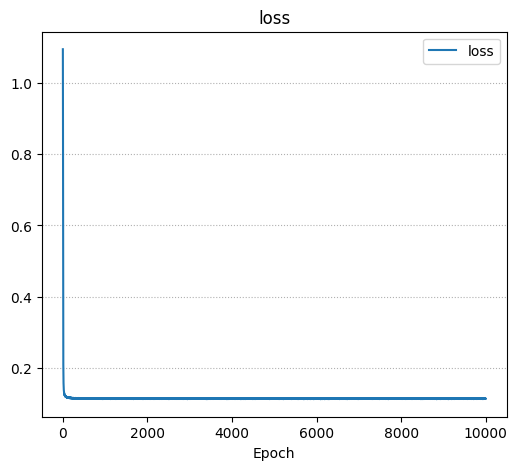

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(scoreList1[0], label="loss")
plt.legend()
plt.xlabel("Epoch")
plt.grid(axis="y", ls=":")
plt.title("loss")
plt.show()


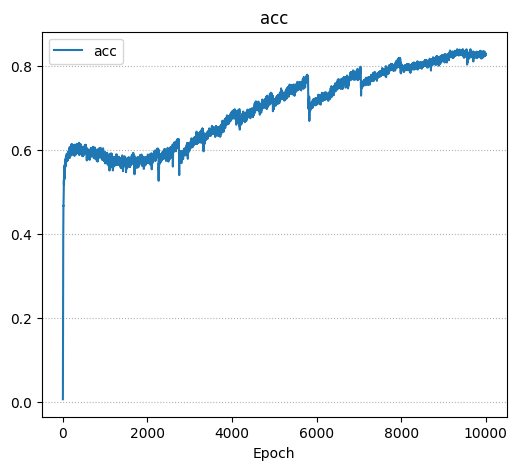

In [172]:
plt.figure(figsize=(6, 5))
plt.plot(scoreList1[1], label="acc")
plt.legend()
plt.xlabel("Epoch")
plt.grid(axis="y", ls=":")
plt.title("acc")
plt.show()


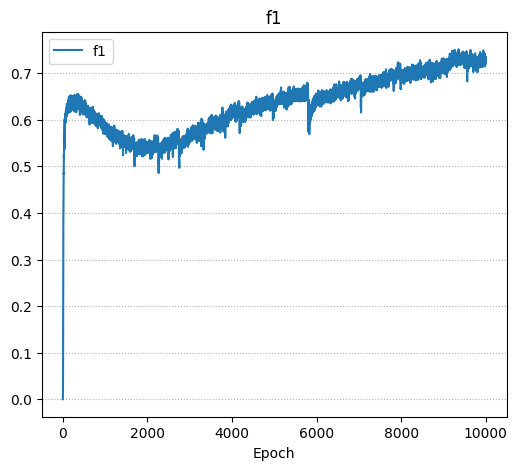

In [173]:
plt.figure(figsize=(6, 5))
plt.plot(scoreList1[2], label="f1")
plt.legend()
plt.xlabel("Epoch")
plt.grid(axis="y", ls=":")
plt.title("f1")
plt.show()
